## Data Preprocessing

### Calculate the VAFs

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from IPython.display import display, HTML

# Set directories
DATA_DIR = 'data'
RESULTS_DIR = 'results'

def parse_strelka2_vcf(vcf_file, sample_name=None, patient_id=None):
    variants = []
    
    with open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
                
            fields = line.strip().split('\t')
            
            if len(fields) < 10:
                continue
                
            chrom = fields[0]
            pos = int(fields[1])
            ref = fields[3]
            alt = fields[4]
            info = fields[7]
            format_fields = fields[8].split(':')
            normal_values = fields[9].split(':')
            tumor_values = fields[10].split(':')
            
            normal_data = dict(zip(format_fields, normal_values))
            tumor_data = dict(zip(format_fields, tumor_values))
            
            nucleotide_to_field = {'A': 'AU', 'C': 'CU', 'G': 'GU', 'T': 'TU'}
            
            try:
                ref_counts_index = format_fields.index(nucleotide_to_field[ref])
                alt_counts_index = format_fields.index(nucleotide_to_field[alt])
            except (ValueError, KeyError):
                continue
                
            tumor_ref_counts = tumor_values[ref_counts_index].split(',')
            tumor_alt_counts = tumor_values[alt_counts_index].split(',')
            
            tier1_ref_counts = int(tumor_ref_counts[0])
            tier1_alt_counts = int(tumor_alt_counts[0])
            
            total_counts = tier1_ref_counts + tier1_alt_counts
            vaf = tier1_alt_counts / total_counts if total_counts > 0 else 0
            
            tumor_depth = int(tumor_data.get('DP', 0))
            is_somatic = "SOMATIC" in info
            
            variant_data = {
                'PATIENT_ID': patient_id,
                'SAMPLE': sample_name,
                'CHROM': chrom,
                'POS': pos,
                'REF': ref,
                'ALT': alt,
                'REF_COUNT': tier1_ref_counts,
                'ALT_COUNT': tier1_alt_counts,
                'TOTAL_COUNT': total_counts,
                'VAF': round(vaf, 4),
                'TUMOR_DEPTH': tumor_depth,
                'SOMATIC': is_somatic
            }
            
            variants.append(variant_data)
    
    variants_df = pd.DataFrame(variants)
    return variants_df

def find_vcf_files(data_dir):
    vcf_files = []
    
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        
        if os.path.isdir(patient_path):
            patient_id = patient_dir
            
            for sample_dir in os.listdir(patient_path):
                sample_path = os.path.join(patient_path, sample_dir)
                
                if os.path.isdir(sample_path):
                    sample_id = sample_dir
                    
                    for filename in os.listdir(sample_path):
                        if filename.endswith("snvs.pass.vcf"):
                            vcf_path = os.path.join(sample_path, filename)
                            
                            vcf_files.append({
                                'patient_id': patient_id,
                                'sample_id': sample_id,
                                'vcf_path': vcf_path
                            })
    
    return vcf_files

def create_manhattan_plot(data, by_sample=True, output_dir=None, patient_id=None):
    multiple_samples = 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1
    
    plt.figure(figsize=(15, 6))
    
    data_copy = data.copy()
    data_copy['CHROM_CLEAN'] = data_copy['CHROM'].str.replace('chr', '')
    
    def chrom_to_num(chrom):
        if chrom in ['X', 'Y', 'M']:
            return {'X': 23, 'Y': 24, 'M': 25}[chrom]
        try:
            return int(chrom)
        except ValueError:
            return 999
    
    data_copy['CHROM_NUM'] = data_copy['CHROM_CLEAN'].apply(chrom_to_num)
    data_copy = data_copy.sort_values(['CHROM_NUM', 'POS'])
    
    chromosomes = data_copy['CHROM'].unique()
    chrom_sizes = {}
    
    for chrom in chromosomes:
        chrom_data = data_copy[data_copy['CHROM'] == chrom]
        if not chrom_data.empty:
            chrom_sizes[chrom] = chrom_data['POS'].max()
    
    chrom_pos = {}
    cum_pos = 0
    
    for chrom in sorted(chromosomes, key=lambda x: data_copy[data_copy['CHROM'] == x]['CHROM_NUM'].iloc[0]):
        chrom_pos[chrom] = cum_pos
        cum_pos += chrom_sizes.get(chrom, 0) + 5000000
    
    data_copy['GENOME_POS'] = data_copy.apply(lambda row: chrom_pos[row['CHROM']] + row['POS'], axis=1)
    
    if multiple_samples and by_sample:
        samples = data_copy['SAMPLE'].unique()
        palette = sns.color_palette("tab10", n_colors=len(samples))
        sample_colors = dict(zip(samples, palette))
        
        for sample, color in sample_colors.items():
            sample_data = data_copy[data_copy['SAMPLE'] == sample]
            plt.scatter(sample_data['GENOME_POS'], sample_data['VAF'], 
                      color=color, alpha=0.7, s=10, label=sample)
        
        plt.legend(title='Sample', loc='upper right')
    else:
        for i, chrom in enumerate(sorted(chromosomes, key=lambda x: data_copy[data_copy['CHROM'] == x]['CHROM_NUM'].iloc[0])):
            chrom_data = data_copy[data_copy['CHROM'] == chrom]
            if not chrom_data.empty:
                plt.scatter(chrom_data['GENOME_POS'], chrom_data['VAF'], 
                          color=f'C{i % 10}', alpha=0.7, s=10, label=chrom)
    
    chrom_midpoints = {}
    for chrom in chromosomes:
        chrom_data = data_copy[data_copy['CHROM'] == chrom]
        if not chrom_data.empty:
            midpoint = chrom_pos[chrom] + chrom_sizes.get(chrom, 0) / 2
            chrom_midpoints[chrom] = midpoint
    
    plt.xticks([midpoint for midpoint in chrom_midpoints.values()], 
              [chrom for chrom in chrom_midpoints.keys()],
              rotation=45)
    
    plt.ylabel('VAF')
    plt.title('VAF Distribution Across the Genome')
    plt.axhline(y=0.5, color='r', linestyle='--', label='VAF = 0.5')
    
    if not (multiple_samples and by_sample):
        handles, labels = plt.gca().get_legend_handles_labels()
        if len(handles) > 10:
            handles = handles[:10]
            labels = labels[:10]
            labels[-1] += "..."
        
        plt.legend(handles, labels, loc='upper right', title='Chromosomes')
    
    plt.xlim(0, cum_pos)
    plt.tight_layout()
    
    if output_dir:
        fig_file = os.path.join(output_dir, f"{patient_id}_manhattan_plot.png")
        plt.savefig(fig_file, dpi=300)
        plt.close()
    else:
        plt.show()

def visualize_vafs(data, by_sample=True, output_dir=None, patient_id=None):
    multiple_samples = 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1
    
    if multiple_samples and by_sample:
        samples = data['SAMPLE'].unique()
        palette = sns.color_palette("tab10", n_colors=len(samples))
        sample_colors = dict(zip(samples, palette))
    
    # Save each plot separately
    
    # 1. VAF Distribution Histogram
    plt.figure(figsize=(8, 6))
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            sns.histplot(sample_data['VAF'], bins=20, kde=True, 
                         label=sample, color=color, alpha=0.5)
        plt.legend(title='Sample')
    else:
        sns.histplot(data['VAF'], bins=20, kde=True)
    
    plt.xlabel('Variant Allele Fraction (VAF)')
    plt.ylabel('Number of Variants')
    plt.title('Distribution of Variant Allele Fractions')
    plt.tight_layout()
    
    if output_dir:
        fig_file = os.path.join(output_dir, f"{patient_id}_vaf_histogram.png")
        plt.savefig(fig_file, dpi=300)
        plt.close()
    else:
        plt.show()
    
    # 2. Scatter plot of VAF vs Read Depth
    plt.figure(figsize=(8, 6))
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            plt.scatter(sample_data['TUMOR_DEPTH'], sample_data['VAF'], 
                       alpha=0.5, color=color, label=sample)
        plt.legend(title='Sample')
    else:
        plt.scatter(data['TUMOR_DEPTH'], data['VAF'], alpha=0.5)
    
    plt.xlabel('Tumor Read Depth')
    plt.ylabel('VAF')
    plt.title('VAF vs. Tumor Read Depth')
    plt.tight_layout()
    
    if output_dir:
        fig_file = os.path.join(output_dir, f"{patient_id}_depth_vs_vaf.png")
        plt.savefig(fig_file, dpi=300)
        plt.close()
    else:
        plt.show()
    
    # 3. VAF by chromosome (boxplot)
    plt.figure(figsize=(10, 6))
    
    chrom_counts = data['CHROM'].value_counts()
    top_chroms = chrom_counts.index[:10].tolist()
    chrom_data = data[data['CHROM'].isin(top_chroms)]
    
    if multiple_samples and by_sample:
        sns.boxplot(x='CHROM', y='VAF', hue='SAMPLE', data=chrom_data, palette=sample_colors)
        plt.legend(title='Sample', loc='upper right')
    else:
        sns.boxplot(x='CHROM', y='VAF', data=chrom_data)
    
    plt.xticks(rotation=45)
    plt.title('VAF Distribution by Chromosome')
    plt.tight_layout()
    
    if output_dir:
        fig_file = os.path.join(output_dir, f"{patient_id}_chrom_boxplot.png")
        plt.savefig(fig_file, dpi=300)
        plt.close()
    else:
        plt.show()
    
    # 4. Alt Count vs. Total Count scatter plot
    plt.figure(figsize=(8, 6))
    
    if multiple_samples and by_sample:
        for sample, color in sample_colors.items():
            sample_data = data[data['SAMPLE'] == sample]
            plt.scatter(sample_data['TOTAL_COUNT'], sample_data['ALT_COUNT'], 
                       alpha=0.7, color=color, label=sample)
        plt.legend(title='Sample')
    else:
        scatter = plt.scatter(data['TOTAL_COUNT'], data['ALT_COUNT'], 
                             c=data['VAF'], cmap='viridis', 
                             alpha=0.7)
        plt.colorbar(scatter, label='VAF')
    
    max_count = max(data['TOTAL_COUNT'])
    plt.plot([0, max_count], [0, max_count/2], 'r--', label='VAF = 0.5')
    
    plt.xlabel('Total Read Count')
    plt.ylabel('Alternate Allele Count')
    plt.title('Alternate vs. Total Read Count')
    plt.legend()
    plt.tight_layout()
    
    if output_dir:
        fig_file = os.path.join(output_dir, f"{patient_id}_alt_vs_total.png")
        plt.savefig(fig_file, dpi=300)
        plt.close()
    else:
        plt.show()
    
    # 5. Create VIOLIN plot for VAF distribution by sample
    if multiple_samples:
        plt.figure(figsize=(10, 6))
        
        # Use violin plot instead of boxplot
        sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,
                     inner='quartile')
        
        plt.xticks(rotation=45)
        plt.title('VAF Distribution by Sample (Violin Plot)')
        plt.tight_layout()
        
        if output_dir:
            fig_file = os.path.join(output_dir, f"{patient_id}_sample_violin.png")
            plt.savefig(fig_file, dpi=300)
            plt.close()
        else:
            plt.show()
    
    # 6. Create Manhattan plot
    create_manhattan_plot(data, by_sample=by_sample, output_dir=output_dir, patient_id=patient_id)

def generate_summary_stats(data, output_dir=None, patient_id=None):
    """
    Generate and save summary statistics for the VAF data
    This is a renamed function to avoid confusion with any other functions
    """
    # Overall stats
    overall_stats = {
        "Total variants": len(data),
        "Mean VAF": data['VAF'].mean(),
        "Median VAF": data['VAF'].median(),
        "Min VAF": data['VAF'].min(),
        "Max VAF": data['VAF'].max()
    }
    
    overall_df = pd.DataFrame([overall_stats])
    
    # Stats by sample if multiple samples
    if 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1:
        sample_summary = data.groupby('SAMPLE').agg({
            'VAF': ['count', 'mean', 'median', 'min', 'max'],
            'TUMOR_DEPTH': ['mean', 'median']
        })
        sample_summary.columns = ['Variant Count', 'Mean VAF', 'Median VAF', 'Min VAF', 'Max VAF', 
                               'Mean Depth', 'Median Depth']
        sample_summary = sample_summary.round(4)
        
        # Chromosome distribution
        chrom_counts = data['CHROM'].value_counts().reset_index()
        chrom_counts.columns = ['Chromosome', 'Count']
        
        # VAF range distribution
        vaf_ranges = [
            (0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4),
            (0.4, 0.5), (0.5, 0.6), (0.6, 1.0)
        ]
        
        vaf_range_data = []
        for vaf_min, vaf_max in vaf_ranges:
            count = ((data['VAF'] >= vaf_min) & (data['VAF'] < vaf_max)).sum()
            percent = (count / len(data)) * 100
            vaf_range_data.append({
                'Range': f"{vaf_min:.1f}-{vaf_max:.1f}",
                'Count': count,
                'Percentage': f"{percent:.1f}%"
            })
        
        vaf_range_df = pd.DataFrame(vaf_range_data)
        
        # Save to CSV files if output directory is provided
        if output_dir:
            overall_stats_file = os.path.join(output_dir, f"{patient_id}_overall_stats.csv")
            sample_summary_file = os.path.join(output_dir, f"{patient_id}_sample_summary.csv")
            chrom_file = os.path.join(output_dir, f"{patient_id}_chromosome_counts.csv")
            vaf_range_file = os.path.join(output_dir, f"{patient_id}_vaf_ranges.csv")
            
            overall_df.to_csv(overall_stats_file, index=False)
            sample_summary.to_csv(sample_summary_file)
            chrom_counts.to_csv(chrom_file, index=False)
            vaf_range_df.to_csv(vaf_range_file, index=False)
            
            print(f"Summary statistics saved to: {output_dir}")
        else:
            # Display in notebook
            print("Overall Statistics:")
            display(overall_df)
            
            print("\nSample Summary:")
            display(sample_summary)
            
            print("\nChromosome Distribution:")
            display(chrom_counts)
            
            print("\nVAF Range Distribution:")
            display(vaf_range_df)
    
    return {
        'overall': overall_df,
        'sample_summary': sample_summary if 'sample_summary' in locals() else None,
        'chrom_counts': chrom_counts if 'chrom_counts' in locals() else None,
        'vaf_ranges': vaf_range_df if 'vaf_range_df' in locals() else None
    }

def compare_samples_shared_variants(data, output_dir=None, patient_id=None):
    """
    Compare variants shared between samples
    """
    if 'SAMPLE' not in data.columns or len(data['SAMPLE'].unique()) <= 1:
        print("This function requires data from multiple samples")
        return
    
    data['VARIANT_ID'] = data['CHROM'] + '_' + data['POS'].astype(str) + '_' + data['REF'] + '_' + data['ALT']
    
    variant_counts = data['VARIANT_ID'].value_counts().reset_index()
    variant_counts.columns = ['VARIANT_ID', 'SAMPLE_COUNT']
    
    shared_data = pd.merge(data, variant_counts, on='VARIANT_ID')
    
    samples = data['SAMPLE'].unique()
    num_samples = len(samples)
    
    # Create summary dataframe for shared variants
    shared_summary = []
    for i in range(1, num_samples + 1):
        count = (shared_data['SAMPLE_COUNT'] == i).sum() // i  # Divide by i because each variant appears i times
        percent = (count / len(variant_counts)) * 100
        
        if i == 1:
            category = "Unique to one sample"
        elif i == num_samples:
            category = f"Shared across all {num_samples} samples"
        else:
            category = f"Shared across {i} samples"
            
        shared_summary.append({
            'Category': category,
            'Count': count,
            'Percentage': f"{percent:.1f}%"
        })
    
    shared_summary_df = pd.DataFrame(shared_summary)
    
    # Save or display
    if output_dir:
        summary_file = os.path.join(output_dir, f"{patient_id}_shared_variants_summary.csv")
        shared_summary_df.to_csv(summary_file, index=False)
    else:
        print("Shared Variants Summary:")
        display(shared_summary_df)
    
    if num_samples >= 2:
        shared_variants = variant_counts[variant_counts['SAMPLE_COUNT'] >= 2]['VARIANT_ID'].tolist()
        
        if shared_variants:
            shared_data = data[data['VARIANT_ID'].isin(shared_variants)]
            
            pivot_vaf = shared_data.pivot_table(
                index='VARIANT_ID', 
                columns='SAMPLE', 
                values='VAF', 
                aggfunc='mean'
            ).reset_index()
            
            if output_dir:
                pivot_file = os.path.join(output_dir, f"{patient_id}_shared_variants_vaf.csv")
                pivot_vaf.to_csv(pivot_file)
                print(f"Shared variants VAF comparison saved to: {pivot_file}")
            else:
                print("\nSample of shared variants VAF comparison:")
                display(pivot_vaf.head(10))
            
            if num_samples > 1:
                plt.figure(figsize=(15, 10))
                plot_idx = 1
                
                for i in range(num_samples):
                    for j in range(i+1, num_samples):
                        sample1 = samples[i]
                        sample2 = samples[j]
                        
                        pair_data = pivot_vaf[[sample1, sample2]].dropna()
                        
                        if len(pair_data) > 0:
                            corr = pair_data[sample1].corr(pair_data[sample2])
                            
                            plt.subplot(num_samples-1, num_samples-1, plot_idx)
                            plt.scatter(pair_data[sample1], pair_data[sample2], alpha=0.5)
                            plt.plot([0, 1], [0, 1], 'r--')  # Identity line
                            plt.xlabel(f'{sample1} VAF')
                            plt.ylabel(f'{sample2} VAF')
                            plt.title(f'Correlation: {corr:.3f}')
                            plt.axis('square')
                            plt.xlim(0, 1)
                            plt.ylim(0, 1)
                        
                        plot_idx += 1
                
                plt.tight_layout()
                
                if output_dir:
                    fig_file = os.path.join(output_dir, f"{patient_id}_vaf_correlations.png")
                    plt.savefig(fig_file, dpi=300)
                    plt.close()
                else:
                    plt.show()
        else:
            print("No variants are shared between samples")
    
    return shared_summary_df

def save_results(data, output_dir, base_filename):
    """
    Save the parsed data to TSV and Excel formats
    """
    # Save to TSV (full dataset with all columns)
    tsv_path = os.path.join(output_dir, f"{base_filename}.tsv")
    data.to_csv(tsv_path, sep='\t', index=False)
    print(f"Data saved to {tsv_path}")
    
    # Generate and save summary statistics
    stats = generate_summary_stats(data, output_dir=output_dir, patient_id=base_filename.split('_')[0])
    
    # Save to Excel if more than one sample
    if 'SAMPLE' in data.columns and len(data['SAMPLE'].unique()) > 1:
        excel_path = os.path.join(output_dir, f"{base_filename}.xlsx")
        
        with pd.ExcelWriter(excel_path) as writer:
            data.to_excel(writer, sheet_name='All Variants', index=False)
            
            # Add samples to separate sheets
            for sample in data['SAMPLE'].unique():
                sample_data = data[data['SAMPLE'] == sample]
                sample_data.to_excel(writer, sheet_name=sample, index=False)
                
            # Add summary sheets
            if stats['overall'] is not None:
                stats['overall'].to_excel(writer, sheet_name='Overall_Stats', index=False)
            if stats['sample_summary'] is not None:
                stats['sample_summary'].to_excel(writer, sheet_name='Sample_Summary')
            if stats['vaf_ranges'] is not None:
                stats['vaf_ranges'].to_excel(writer, sheet_name='VAF_Ranges', index=False)
        
        print(f"Excel workbook with multiple sheets saved to {excel_path}")
    
    return {
        'full_path': tsv_path,
        'excel_path': excel_path if 'excel_path' in locals() else None
    }

def process_patient_vcfs(data_dir=DATA_DIR, results_dir=RESULTS_DIR, patient_id=None):
    """
    Process VCF files for a specific patient or all patients
    """
    # Find all VCF files
    all_vcf_files = find_vcf_files(data_dir)
    
    # Filter by patient if specified
    if patient_id:
        vcf_files = [f for f in all_vcf_files if f['patient_id'] == patient_id]
    else:
        vcf_files = all_vcf_files
    
    # Group by patient
    patient_vcfs = {}
    for vcf_file in vcf_files:
        patient = vcf_file['patient_id']
        if patient not in patient_vcfs:
            patient_vcfs[patient] = []
        patient_vcfs[patient].append(vcf_file)
    
    # Process each patient's VCF files
    patient_variants = {}
    
    for patient, files in patient_vcfs.items():
        print(f"Processing patient: {patient}")
        
        # Create results directory for this patient
        patient_results_dir = os.path.join(results_dir, patient)
        
        all_patient_variants = []
        
        # Process each sample for this patient
        for file_info in files:
            vcf_path = file_info['vcf_path']
            sample_id = file_info['sample_id']
            
            print(f"  Processing sample: {sample_id}, file: {os.path.basename(vcf_path)}")
            
            try:
                variants_df = parse_strelka2_vcf(vcf_path, sample_name=sample_id, patient_id=patient)
                all_patient_variants.append(variants_df)
                print(f"    Found {len(variants_df)} variants in sample {sample_id}")
            except Exception as e:
                print(f"    Error processing {vcf_path}: {e}")
        
        # Combine all variants for this patient
        if all_patient_variants:
            combined_df = pd.concat(all_patient_variants, ignore_index=True)
            print(f"  Total variants for patient {patient}: {len(combined_df)}")
            
            # Save the variants
            save_results(combined_df, patient_results_dir, f"{patient}_variants")
            
            # Generate and save visualizations
            print(f"  Generating visualizations for patient {patient}...")
            visualize_vafs(combined_df, by_sample=True, output_dir=patient_results_dir, patient_id=patient)
            
            # Compare samples if there are multiple
            if 'SAMPLE' in combined_df.columns and len(combined_df['SAMPLE'].unique()) > 1:
                print(f"  Comparing samples for patient {patient}...")
                compare_samples_shared_variants(combined_df, output_dir=patient_results_dir, patient_id=patient)
            
            # Save the data for return
            patient_variants[patient] = combined_df
        else:
            print(f"  No variants found for patient {patient}")
    
    return patient_variants

# For use in Jupyter Notebook - run this cell to process all patients
if __name__ == "__main__":
    # Process all patients or specific patient
    # To process a specific patient, use: process_patient_vcfs(patient_id='G12')
    all_patient_variants = process_patient_vcfs()
    
    print(f"\nProcessed {len(all_patient_variants)} patients:")
    for patient, variants in all_patient_variants.items():
        sample_count = len(variants['SAMPLE'].unique())
        print(f"  - {patient}: {len(variants)} variants across {sample_count} samples")

Processing patient: p191
  Processing sample: 41126, file: somatic.XY.snvs.pass.vcf
    Found 434 variants in sample 41126
  Processing sample: 41133, file: somatic.XY.snvs.pass.vcf
    Found 440 variants in sample 41133
  Processing sample: 41114, file: somatic.XY.snvs.pass.vcf
    Found 398 variants in sample 41114
  Processing sample: 42407, file: somatic.XY.snvs.pass.vcf
    Found 313 variants in sample 42407
  Total variants for patient p191: 1585
Data saved to results/p191/p191_variants.tsv
Summary statistics saved to: results/p191
Excel workbook with multiple sheets saved to results/p191/p191_variants.xlsx
  Generating visualizations for patient p191...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient p191...
Shared variants VAF comparison saved to: results/p191/p191_shared_variants_vaf.csv
Processing patient: P163
  Processing sample: 375363, file: somatic.XX.snvs.pass.vcf
    Found 576 variants in sample 375363
  Processing sample: 376223, file: somatic.XX.snvs.pass.vcf
    Found 671 variants in sample 376223
  Processing sample: 376213, file: somatic.XX.snvs.pass.vcf
    Found 651 variants in sample 376213
  Processing sample: 376137, file: somatic.XX.snvs.pass.vcf
    Found 467 variants in sample 376137
  Processing sample: 376121, file: somatic.XX.snvs.pass.vcf
    Found 888 variants in sample 376121
  Processing sample: 375380, file: somatic.XX.snvs.pass.vcf
    Found 597 variants in sample 375380
  Total variants for patient P163: 3850
Data saved to results/P163/P163_variants.tsv
Summary statistics saved to: results/P163
Excel workbook with multiple sheets saved to results/P163/P163_variants.xlsx
  Generating visualizations for patient P163...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient P163...
Shared variants VAF comparison saved to: results/P163/P163_shared_variants_vaf.csv
Processing patient: P190
  Processing sample: 359388, file: somatic.XX.snvs.pass.vcf
    Found 802 variants in sample 359388
  Processing sample: 359227, file: somatic.XX.snvs.pass.vcf
    Found 891 variants in sample 359227
  Processing sample: 359287, file: somatic.XX.snvs.pass.vcf
    Found 611 variants in sample 359287
  Processing sample: 359261, file: somatic.XX.snvs.pass.vcf
    Found 581 variants in sample 359261
  Processing sample: 359313, file: somatic.XX.snvs.pass.vcf
    Found 598 variants in sample 359313
  Total variants for patient P190: 3483
Data saved to results/P190/P190_variants.tsv
Summary statistics saved to: results/P190
Excel workbook with multiple sheets saved to results/P190/P190_variants.xlsx
  Generating visualizations for patient P190...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient P190...
Shared variants VAF comparison saved to: results/P190/P190_shared_variants_vaf.csv
Processing patient: p152
  Processing sample: 387930, file: somatic.XY.snvs.pass.vcf
    Found 493 variants in sample 387930
  Processing sample: 388519, file: somatic.XY.snvs.pass.vcf
    Found 726 variants in sample 388519
  Processing sample: 387947, file: somatic.XY.snvs.pass.vcf
    Found 610 variants in sample 387947
  Processing sample: 387979, file: somatic.XY.snvs.pass.vcf
    Found 455 variants in sample 387979
  Processing sample: 387720, file: somatic.XY.snvs.pass.vcf
    Found 584 variants in sample 387720
  Processing sample: 387942, file: somatic.XY.snvs.pass.vcf
    Found 610 variants in sample 387942
  Processing sample: 388615, file: somatic.XY.snvs.pass.vcf
    Found 737 variants in sample 388615
  Total variants for patient p152: 4215
Data saved to results/p152/p152_variants.tsv
Summary statistics saved to: results/p152
Excel workbook with multi

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient p152...
Shared variants VAF comparison saved to: results/p152/p152_shared_variants_vaf.csv
Processing patient: M36
  Processing sample: R, file: somatic.XY.snvs.pass.vcf
    Found 605 variants in sample R
  Processing sample: N, file: somatic.XY.snvs.pass.vcf
    Found 520 variants in sample N
  Processing sample: T, file: somatic.XY.snvs.pass.vcf
    Found 951 variants in sample T
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 1265 variants in sample F
  Processing sample: E, file: somatic.XY.snvs.pass.vcf
    Found 965 variants in sample E
  Processing sample: K, file: somatic.XY.snvs.pass.vcf
    Found 591 variants in sample K
  Processing sample: P, file: somatic.XY.snvs.pass.vcf
    Found 434 variants in sample P
  Total variants for patient M36: 5331
Data saved to results/M36/M36_variants.tsv
Summary statistics saved to: results/M36
Excel workbook with multiple sheets saved to results/M36/M36_variants.xlsx
  Generating visualizati

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient M36...
Shared variants VAF comparison saved to: results/M36/M36_shared_variants_vaf.csv
Processing patient: G53
  Processing sample: I, file: somatic.XX.snvs.pass.vcf
    Found 957 variants in sample I
  Processing sample: A, file: somatic.XX.snvs.pass.vcf
    Found 529 variants in sample A
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 764 variants in sample F
  Processing sample: J, file: somatic.XX.snvs.pass.vcf
    Found 799 variants in sample J
  Processing sample: C, file: somatic.XX.snvs.pass.vcf
    Found 967 variants in sample C
  Processing sample: D, file: somatic.XX.snvs.pass.vcf
    Found 977 variants in sample D
  Processing sample: E, file: somatic.XX.snvs.pass.vcf
    Found 947 variants in sample E
  Processing sample: B, file: somatic.XX.snvs.pass.vcf
    Found 719 variants in sample B
  Processing sample: K, file: somatic.XX.snvs.pass.vcf
    Found 961 variants in sample K
  Total variants for patient G53: 7620
Data sa

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G53...
Shared variants VAF comparison saved to: results/G53/G53_shared_variants_vaf.csv
Processing patient: G39
  Processing sample: G, file: somatic.XY.snvs.pass.vcf
    Found 608 variants in sample G
  Processing sample: A, file: somatic.XY.snvs.pass.vcf
    Found 525 variants in sample A
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 546 variants in sample F
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 910 variants in sample C
  Processing sample: E, file: somatic.XY.snvs.pass.vcf
    Found 519 variants in sample E
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 743 variants in sample B
  Total variants for patient G39: 3851
Data saved to results/G39/G39_variants.tsv
Summary statistics saved to: results/G39
Excel workbook with multiple sheets saved to results/G39/G39_variants.xlsx
  Generating visualizations for patient G39...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G39...
Shared variants VAF comparison saved to: results/G39/G39_shared_variants_vaf.csv
Processing patient: G97
  Processing sample: I, file: somatic.XY.snvs.pass.vcf
    Found 702 variants in sample I
  Processing sample: G, file: somatic.XY.snvs.pass.vcf
    Found 1432 variants in sample G
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 15273 variants in sample F
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 1197 variants in sample H
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 857 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 921 variants in sample D
  Processing sample: E, file: somatic.XY.snvs.pass.vcf
    Found 663 variants in sample E
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 10976 variants in sample B
  Total variants for patient G97: 32021
Data saved to results/G97/G97_variants.tsv
Summary statistics saved to: results/G97
Excel 

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G97...
Shared variants VAF comparison saved to: results/G97/G97_shared_variants_vaf.csv
Processing patient: G52
  Processing sample: A, file: somatic.XX.snvs.pass.vcf
    Found 565 variants in sample A
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 445 variants in sample F
  Processing sample: H, file: somatic.XX.snvs.pass.vcf
    Found 592 variants in sample H
  Processing sample: M, file: somatic.XX.snvs.pass.vcf
    Found 493 variants in sample M
  Processing sample: J, file: somatic.XX.snvs.pass.vcf
    Found 499 variants in sample J
  Processing sample: C, file: somatic.XX.snvs.pass.vcf
    Found 355 variants in sample C
  Processing sample: D, file: somatic.XX.snvs.pass.vcf
    Found 590 variants in sample D
  Processing sample: E, file: somatic.XX.snvs.pass.vcf
    Found 605 variants in sample E
  Processing sample: B, file: somatic.XX.snvs.pass.vcf
    Found 440 variants in sample B
  Processing sample: L, file: somatic.XX.snvs.

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G52...
Shared variants VAF comparison saved to: results/G52/G52_shared_variants_vaf.csv
Processing patient: G99
  Processing sample: I, file: somatic.XX.snvs.pass.vcf
    Found 12006 variants in sample I
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 12178 variants in sample F
  Processing sample: E, file: somatic.XX.snvs.pass.vcf
    Found 8903 variants in sample E
  Processing sample: K, file: somatic.XX.snvs.pass.vcf
    Found 12422 variants in sample K
  Total variants for patient G99: 45509
Data saved to results/G99/G99_variants.tsv
Summary statistics saved to: results/G99
Excel workbook with multiple sheets saved to results/G99/G99_variants.xlsx
  Generating visualizations for patient G99...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G99...
Shared variants VAF comparison saved to: results/G99/G99_shared_variants_vaf.csv
Processing patient: G77
  Processing sample: I, file: somatic.XY.snvs.pass.vcf
    Found 1007 variants in sample I
  Processing sample: G, file: somatic.XY.snvs.pass.vcf
    Found 1679 variants in sample G
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 1186 variants in sample F
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 1237 variants in sample H
  Processing sample: J, file: somatic.XY.snvs.pass.vcf
    Found 796 variants in sample J
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 771 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 1095 variants in sample D
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 1073 variants in sample B
  Total variants for patient G77: 8844
Data saved to results/G77/G77_variants.tsv
Summary statistics saved to: results/G77
Excel w

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G77...
Shared variants VAF comparison saved to: results/G77/G77_shared_variants_vaf.csv
Processing patient: G12
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 2469 variants in sample F
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 1916 variants in sample C
  Processing sample: E, file: somatic.XY.snvs.pass.vcf
    Found 1903 variants in sample E
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 1873 variants in sample B
  Total variants for patient G12: 8161
Data saved to results/G12/G12_variants.tsv
Summary statistics saved to: results/G12
Excel workbook with multiple sheets saved to results/G12/G12_variants.xlsx
  Generating visualizations for patient G12...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G12...
Shared variants VAF comparison saved to: results/G12/G12_shared_variants_vaf.csv
Processing patient: M24
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 875 variants in sample F
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 792 variants in sample C
  Processing sample: E, file: somatic.XY.snvs.pass.vcf
    Found 713 variants in sample E
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 925 variants in sample B
  Total variants for patient M24: 3305
Data saved to results/M24/M24_variants.tsv
Summary statistics saved to: results/M24
Excel workbook with multiple sheets saved to results/M24/M24_variants.xlsx
  Generating visualizations for patient M24...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient M24...
Shared variants VAF comparison saved to: results/M24/M24_shared_variants_vaf.csv
Processing patient: G23
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 870 variants in sample F
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 785 variants in sample H
  Processing sample: B1, file: somatic.XY.snvs.pass.vcf
    Found 883 variants in sample B1
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 929 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 1182 variants in sample D
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 508 variants in sample B
  Total variants for patient G23: 5157
Data saved to results/G23/G23_variants.tsv
Summary statistics saved to: results/G23
Excel workbook with multiple sheets saved to results/G23/G23_variants.xlsx
  Generating visualizations for patient G23...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G23...
Shared variants VAF comparison saved to: results/G23/G23_shared_variants_vaf.csv
Processing patient: G40
  Processing sample: I, file: somatic.XX.snvs.pass.vcf
    Found 527 variants in sample I
  Processing sample: G, file: somatic.XX.snvs.pass.vcf
    Found 561 variants in sample G
  Processing sample: A, file: somatic.XX.snvs.pass.vcf
    Found 504 variants in sample A
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 550 variants in sample F
  Processing sample: M, file: somatic.XX.snvs.pass.vcf
    Found 580 variants in sample M
  Processing sample: C, file: somatic.XX.snvs.pass.vcf
    Found 574 variants in sample C
  Processing sample: D, file: somatic.XX.snvs.pass.vcf
    Found 562 variants in sample D
  Processing sample: E, file: somatic.XX.snvs.pass.vcf
    Found 508 variants in sample E
  Processing sample: K, file: somatic.XX.snvs.pass.vcf
    Found 575 variants in sample K
  Total variants for patient G40: 4941
Data sa

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G40...
Shared variants VAF comparison saved to: results/G40/G40_shared_variants_vaf.csv
Processing patient: M78
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 649 variants in sample F
  Processing sample: H, file: somatic.XX.snvs.pass.vcf
    Found 708 variants in sample H
  Processing sample: J, file: somatic.XX.snvs.pass.vcf
    Found 1532 variants in sample J
  Processing sample: C, file: somatic.XX.snvs.pass.vcf
    Found 1176 variants in sample C
  Processing sample: B, file: somatic.XX.snvs.pass.vcf
    Found 806 variants in sample B
  Total variants for patient M78: 4871
Data saved to results/M78/M78_variants.tsv
Summary statistics saved to: results/M78
Excel workbook with multiple sheets saved to results/M78/M78_variants.xlsx
  Generating visualizations for patient M78...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient M78...
Shared variants VAF comparison saved to: results/M78/M78_shared_variants_vaf.csv
Processing patient: G85
  Processing sample: I, file: somatic.XX.snvs.pass.vcf
    Found 727 variants in sample I
  Processing sample: G, file: somatic.XX.snvs.pass.vcf
    Found 1107 variants in sample G
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 989 variants in sample F
  Processing sample: H, file: somatic.XX.snvs.pass.vcf
    Found 1258 variants in sample H
  Processing sample: C, file: somatic.XX.snvs.pass.vcf
    Found 1038 variants in sample C
  Processing sample: D, file: somatic.XX.snvs.pass.vcf
    Found 934 variants in sample D
  Processing sample: B, file: somatic.XX.snvs.pass.vcf
    Found 2363 variants in sample B
  Total variants for patient G85: 8416
Data saved to results/G85/G85_variants.tsv
Summary statistics saved to: results/G85
Excel workbook with multiple sheets saved to results/G85/G85_variants.xlsx
  Generating visualizati

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G85...
Shared variants VAF comparison saved to: results/G85/G85_shared_variants_vaf.csv
Processing patient: p182
  Processing sample: 112083, file: somatic.XY.snvs.pass.vcf
    Found 568 variants in sample 112083
  Processing sample: 111761, file: somatic.XY.snvs.pass.vcf
    Found 602 variants in sample 111761
  Processing sample: 111948, file: somatic.XY.snvs.pass.vcf
    Found 322 variants in sample 111948
  Processing sample: 11967, file: somatic.XY.snvs.pass.vcf
    Found 413 variants in sample 11967
  Total variants for patient p182: 1905
Data saved to results/p182/p182_variants.tsv
Summary statistics saved to: results/p182
Excel workbook with multiple sheets saved to results/p182/p182_variants.xlsx
  Generating visualizations for patient p182...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient p182...
Shared variants VAF comparison saved to: results/p182/p182_shared_variants_vaf.csv
Processing patient: P158
  Processing sample: 375150, file: somatic.XX.snvs.pass.vcf
    Found 534 variants in sample 375150
  Processing sample: 375281, file: somatic.XX.snvs.pass.vcf
    Found 634 variants in sample 375281
  Processing sample: 375266, file: somatic.XX.snvs.pass.vcf
    Found 689 variants in sample 375266
  Processing sample: 375284, file: somatic.XX.snvs.pass.vcf
    Found 534 variants in sample 375284
  Processing sample: 375546, file: somatic.XX.snvs.pass.vcf
    Found 463 variants in sample 375546
  Total variants for patient P158: 2854
Data saved to results/P158/P158_variants.tsv
Summary statistics saved to: results/P158
Excel workbook with multiple sheets saved to results/P158/P158_variants.xlsx
  Generating visualizations for patient P158...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient P158...
Shared variants VAF comparison saved to: results/P158/P158_shared_variants_vaf.csv
Processing patient: G5
  Processing sample: I, file: somatic.XY.snvs.pass.vcf
    Found 461 variants in sample I
  Processing sample: G, file: somatic.XY.snvs.pass.vcf
    Found 516 variants in sample G
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 541 variants in sample H
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 467 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 485 variants in sample D
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 497 variants in sample B
  Total variants for patient G5: 2967
Data saved to results/G5/G5_variants.tsv
Summary statistics saved to: results/G5
Excel workbook with multiple sheets saved to results/G5/G5_variants.xlsx
  Generating visualizations for patient G5...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G5...
Shared variants VAF comparison saved to: results/G5/G5_shared_variants_vaf.csv
Processing patient: M95
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 896 variants in sample F
  Processing sample: M, file: somatic.XY.snvs.pass.vcf
    Found 781 variants in sample M
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 917 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 1281 variants in sample D
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 1029 variants in sample B
  Processing sample: L, file: somatic.XY.snvs.pass.vcf
    Found 591 variants in sample L
  Total variants for patient M95: 5495
Data saved to results/M95/M95_variants.tsv
Summary statistics saved to: results/M95
Excel workbook with multiple sheets saved to results/M95/M95_variants.xlsx
  Generating visualizations for patient M95...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient M95...
Shared variants VAF comparison saved to: results/M95/M95_shared_variants_vaf.csv
Processing patient: G92
  Processing sample: G, file: somatic.XY.snvs.pass.vcf
    Found 843 variants in sample G
  Processing sample: F, file: somatic.XY.snvs.pass.vcf
    Found 52570 variants in sample F
  Processing sample: M, file: somatic.XY.snvs.pass.vcf
    Found 1256 variants in sample M
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 1425 variants in sample C
  Processing sample: D, file: somatic.XY.snvs.pass.vcf
    Found 737 variants in sample D
  Processing sample: K, file: somatic.XY.snvs.pass.vcf
    Found 765 variants in sample K
  Total variants for patient G92: 57596
Data saved to results/G92/G92_variants.tsv
Summary statistics saved to: results/G92
Excel workbook with multiple sheets saved to results/G92/G92_variants.xlsx
  Generating visualizations for patient G92...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G92...
Shared variants VAF comparison saved to: results/G92/G92_shared_variants_vaf.csv
Processing patient: G59
  Processing sample: I, file: somatic.XX.snvs.pass.vcf
    Found 475 variants in sample I
  Processing sample: F, file: somatic.XX.snvs.pass.vcf
    Found 532 variants in sample F
  Processing sample: H, file: somatic.XX.snvs.pass.vcf
    Found 491 variants in sample H
  Processing sample: J, file: somatic.XX.snvs.pass.vcf
    Found 1155 variants in sample J
  Processing sample: D, file: somatic.XX.snvs.pass.vcf
    Found 1003 variants in sample D
  Processing sample: E, file: somatic.XX.snvs.pass.vcf
    Found 452 variants in sample E
  Processing sample: B, file: somatic.XX.snvs.pass.vcf
    Found 480 variants in sample B
  Processing sample: K, file: somatic.XX.snvs.pass.vcf
    Found 1121 variants in sample K
  Processing sample: L, file: somatic.XX.snvs.pass.vcf
    Found 502 variants in sample L
  Total variants for patient G59: 6211
Data

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G59...
Shared variants VAF comparison saved to: results/G59/G59_shared_variants_vaf.csv
Processing patient: G87
  Processing sample: A, file: somatic.XY.snvs.pass.vcf
    Found 665 variants in sample A
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 1029 variants in sample H
  Processing sample: J, file: somatic.XY.snvs.pass.vcf
    Found 1647 variants in sample J
  Processing sample: K, file: somatic.XY.snvs.pass.vcf
    Found 1088 variants in sample K
  Total variants for patient G87: 4429
Data saved to results/G87/G87_variants.tsv
Summary statistics saved to: results/G87
Excel workbook with multiple sheets saved to results/G87/G87_variants.xlsx
  Generating visualizations for patient G87...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G87...
Shared variants VAF comparison saved to: results/G87/G87_shared_variants_vaf.csv
Processing patient: p065
  Processing sample: 359303, file: somatic.XX.snvs.pass.vcf
    Found 484 variants in sample 359303
  Processing sample: 359319, file: somatic.XX.snvs.pass.vcf
    Found 481 variants in sample 359319
  Processing sample: 359306, file: somatic.XX.snvs.pass.vcf
    Found 651 variants in sample 359306
  Processing sample: 358799, file: somatic.XX.snvs.pass.vcf
    Found 462 variants in sample 358799
  Processing sample: 359322, file: somatic.XX.snvs.pass.vcf
    Found 35428 variants in sample 359322
  Processing sample: 358802, file: somatic.XX.snvs.pass.vcf
    Found 332 variants in sample 358802
  Total variants for patient p065: 37838
Data saved to results/p065/p065_variants.tsv
Summary statistics saved to: results/p065
Excel workbook with multiple sheets saved to results/p065/p065_variants.xlsx
  Generating visualizations for patient p065...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient p065...
Shared variants VAF comparison saved to: results/p065/p065_shared_variants_vaf.csv
Processing patient: G45
  Processing sample: H, file: somatic.XY.snvs.pass.vcf
    Found 626 variants in sample H
  Processing sample: M, file: somatic.XY.snvs.pass.vcf
    Found 604 variants in sample M
  Processing sample: B, file: somatic.XY.snvs.pass.vcf
    Found 1247 variants in sample B
  Processing sample: K, file: somatic.XY.snvs.pass.vcf
    Found 724 variants in sample K
  Processing sample: L, file: somatic.XY.snvs.pass.vcf
    Found 605 variants in sample L
  Total variants for patient G45: 3806
Data saved to results/G45/G45_variants.tsv
Summary statistics saved to: results/G45
Excel workbook with multiple sheets saved to results/G45/G45_variants.xlsx
  Generating visualizations for patient G45...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G45...
Shared variants VAF comparison saved to: results/G45/G45_shared_variants_vaf.csv
Processing patient: G43
  Processing sample: R, file: somatic.XY.snvs.pass.vcf
    Found 1807 variants in sample R
  Processing sample: I, file: somatic.XY.snvs.pass.vcf
    Found 881 variants in sample I
  Processing sample: T, file: somatic.XY.snvs.pass.vcf
    Found 781 variants in sample T
  Processing sample: C, file: somatic.XY.snvs.pass.vcf
    Found 831 variants in sample C
  Processing sample: P, file: somatic.XY.snvs.pass.vcf
    Found 548 variants in sample P
  Total variants for patient G43: 4848
Data saved to results/G43/G43_variants.tsv
Summary statistics saved to: results/G43
Excel workbook with multiple sheets saved to results/G43/G43_variants.xlsx
  Generating visualizations for patient G43...


/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient G43...
Shared variants VAF comparison saved to: results/G43/G43_shared_variants_vaf.csv
Processing patient: p129
  Processing sample: 376176, file: somatic.XX.snvs.pass.vcf
    Found 589 variants in sample 376176
  Processing sample: 376050, file: somatic.XX.snvs.pass.vcf
    Found 458 variants in sample 376050
  Processing sample: 375688, file: somatic.XX.snvs.pass.vcf
    Found 630 variants in sample 375688
  Processing sample: 376304, file: somatic.XX.snvs.pass.vcf
    Found 602 variants in sample 376304
  Processing sample: 376165, file: somatic.XX.snvs.pass.vcf
    Found 543 variants in sample 376165
  Processing sample: 375970, file: somatic.XX.snvs.pass.vcf
    Found 448 variants in sample 375970
  Processing sample: 376085, file: somatic.XX.snvs.pass.vcf
    Found 506 variants in sample 376085
  Processing sample: 375973, file: somatic.XX.snvs.pass.vcf
    Found 649 variants in sample 375973
  Processing sample: 375918, file: somatic.XX.snvs.pass

/var/folders/ct/zks035_n5vn9xb6d7n4xk5200000gn/T/ipykernel_21952/839645181.py:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='SAMPLE', y='VAF', data=data, palette=sample_colors if by_sample else None,


  Comparing samples for patient p129...
Shared variants VAF comparison saved to: results/p129/p129_shared_variants_vaf.csv

Processed 28 patients:
  - p191: 1585 variants across 4 samples
  - P163: 3850 variants across 6 samples
  - P190: 3483 variants across 5 samples
  - p152: 4215 variants across 7 samples
  - M36: 5331 variants across 7 samples
  - G53: 7620 variants across 9 samples
  - G39: 3851 variants across 6 samples
  - G97: 32021 variants across 8 samples
  - G52: 5098 variants across 10 samples
  - G99: 45509 variants across 4 samples
  - G77: 8844 variants across 8 samples
  - G12: 8161 variants across 4 samples
  - M24: 3305 variants across 4 samples
  - G23: 5157 variants across 6 samples
  - G40: 4941 variants across 9 samples
  - M78: 4871 variants across 5 samples
  - G85: 8416 variants across 7 samples
  - p182: 1905 variants across 4 samples
  - P158: 2854 variants across 5 samples
  - G5: 2967 variants across 6 samples
  - M95: 5495 variants across 6 samples
  - G

## PyClone-VI

### Convert the VAF data into the format expected by PyClone-VI

In [125]:
# Standalone VCF to PyClone-VI Converter
# This code reads variant data from TSV files in the results directory
# and saves PyClone input files in the same patient directories

import pandas as pd
import os
import glob

def get_patient_variant_files(results_dir="results"):
    """
    Find all patient variant TSV files in the results directory
    
    Args:
        results_dir (str): Path to the results directory
        
    Returns:
        dict: Dictionary mapping patient IDs to their variant file paths
    """
    patient_files = {}
    
    # Look for patient directories in the results directory
    patient_dirs = glob.glob(os.path.join(results_dir, "*"))
    
    for patient_dir in patient_dirs:
        if os.path.isdir(patient_dir):
            # Extract patient ID from directory name
            patient_id = os.path.basename(patient_dir)
            
            # Look for variant TSV file with patient ID prefix
            variant_file_pattern = os.path.join(patient_dir, f"{patient_id}_variants.tsv")
            variant_files = glob.glob(variant_file_pattern)
            
            if variant_files:
                patient_files[patient_id] = variant_files[0]
                print(f"Found variant file for patient {patient_id}: {variant_files[0]}")
    
    if not patient_files:
        print(f"No patient variant files found in {results_dir}")
    
    return patient_files

def process_patient_variants(patient_id, variant_file, output_dir=None, 
                            default_tumor_content=0.5,
                            min_coverage=20, min_vaf=0.05):
    """
    Process a single patient's variants and convert to PyClone format
    
    Args:
        patient_id (str): Patient identifier
        variant_file (str): Path to patient's variant TSV file
        output_dir (str): Directory to save output (if None, save in same directory as input)
        default_tumor_content (float): Default tumor purity estimate (0-1)
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        
    Returns:
        pd.DataFrame: PyClone formatted data for the patient
    """
    # Determine output directory
    if output_dir is None:
        output_dir = os.path.dirname(variant_file)
    
    print(f"Processing patient {patient_id}...")
    
    try:
        # Read variant file
        variants_df = pd.read_csv(variant_file, sep='\t')
        print(f"  Loaded {len(variants_df)} variants")
        
        # Make sure we have the required columns
        required_columns = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT', 'TOTAL_COUNT', 'VAF', 'SAMPLE']
        missing_columns = [col for col in required_columns if col not in variants_df.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns in variant file: {', '.join(missing_columns)}")
        
        # Filter variants by coverage and VAF
        filtered_variants = variants_df[
            (variants_df['TOTAL_COUNT'] >= min_coverage) & 
            (variants_df['VAF'] >= min_vaf)
        ].copy()
        
        print(f"  Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
        print(f"    Minimum coverage: {min_coverage}")
        print(f"    Minimum VAF: {min_vaf}")
        
        # Get unique samples for this patient
        samples = filtered_variants['SAMPLE'].unique()
        print(f"  Found {len(samples)} samples: {', '.join(samples)}")
        
        # Process each sample
        sample_pyclone_dfs = {}
        
        for sample in samples:
            sample_data = filtered_variants[filtered_variants['SAMPLE'] == sample]
            print(f"  Processing sample {sample}: {len(sample_data)} variants")
            
            # Convert to PyClone format
            pyclone_data = []
            for _, row in sample_data.iterrows():
                # Create mutation_id from chromosome and position
                mutation_id = f"{row['CHROM']}:{row['POS']}:{row['REF']}>{row['ALT']}"
                
                # Set default copy number values (assuming diploid)
                normal_cn = 2  # Assuming autosomal
                major_cn = 1   # Default major copy number
                minor_cn = 1   # Default minor copy number
                
                # Adjust for sex chromosomes
                if row['CHROM'] in ['chrX', 'X', 'chrY', 'Y']:
                    if row['CHROM'] in ['chrX', 'X']:
                        # Set X chromosome values (assuming female)
                        pass  # Using defaults
                    elif row['CHROM'] in ['chrY', 'Y']:
                        # Set Y chromosome values (assuming male)
                        normal_cn = 1
                        major_cn = 1
                        minor_cn = 0
                
                # Add to PyClone data
                pyclone_data.append({
                    'mutation_id': mutation_id,
                    'sample_id': sample,
                    'ref_counts': row['REF_COUNT'],
                    'alt_counts': row['ALT_COUNT'],
                    'normal_cn': normal_cn,
                    'major_cn': major_cn,
                    'minor_cn': minor_cn,
                    'tumor_content': default_tumor_content
                })
            
            # Create PyClone DataFrame for this sample
            sample_pyclone_df = pd.DataFrame(pyclone_data)
            sample_pyclone_dfs[sample] = sample_pyclone_df
        
        # Combine all samples for this patient into a single PyClone file
        combined_pyclone_df = pd.concat(sample_pyclone_dfs.values(), ignore_index=True)
        
        # Save combined file to patient's directory
        output_file = os.path.join(output_dir, f"{patient_id}_pyclone_input.tsv")
        combined_pyclone_df.to_csv(output_file, sep='\t', index=False)
        print(f"  Saved combined PyClone input for patient {patient_id} to {output_file}")
        
        return combined_pyclone_df
        
    except Exception as e:
        print(f"  Error processing patient {patient_id}: {e}")
        return None

# Main execution block
if __name__ == "__main__":
    # Set parameters
    results_directory = "results"  # Directory containing patient subdirectories
    tumor_purity = 1.0            # Estimated tumor purity (0-1)
    min_read_coverage = 1         # Minimum total reads required
    min_vaf_threshold = 0.0       # Minimum VAF required (0%)
    
    # Get all patient variant files
    print(f"Finding patient variant files in {results_directory}")
    patient_files = get_patient_variant_files(results_dir=results_directory)
    
    if not patient_files:
        print("No patient variant files found. Exiting.")
        exit(1)
    
    # Process each patient independently
    pyclone_results = {}
    for patient_id, variant_file in patient_files.items():
        pyclone_df = process_patient_variants(
            patient_id,
            variant_file,
            default_tumor_content=tumor_purity,
            min_coverage=min_read_coverage,
            min_vaf=min_vaf_threshold
        )
        
        if pyclone_df is not None:
            pyclone_results[patient_id] = pyclone_df
    
    # Display summary
    print("\nPyClone conversion complete:")
    for patient, data in pyclone_results.items():
        print(f"  Patient {patient}: {len(data)} variants processed across {len(data['sample_id'].unique())} samples")
        
    # Display the first few rows of the first patient's PyClone input
    if pyclone_results:
        first_patient = list(pyclone_results.keys())[0]
        print(f"\nFirst few rows of PyClone input for patient {first_patient}:")
        print(pyclone_results[first_patient].head())

Finding patient variant files in results
Found variant file for patient p191: results/p191/p191_variants.tsv
Found variant file for patient P163: results/P163/P163_variants.tsv
Found variant file for patient P190: results/P190/P190_variants.tsv
Found variant file for patient p152: results/p152/p152_variants.tsv
Found variant file for patient M36: results/M36/M36_variants.tsv
Found variant file for patient G53: results/G53/G53_variants.tsv
Found variant file for patient G39: results/G39/G39_variants.tsv
Found variant file for patient G97: results/G97/G97_variants.tsv
Found variant file for patient G52: results/G52/G52_variants.tsv
Found variant file for patient G99: results/G99/G99_variants.tsv
Found variant file for patient G77: results/G77/G77_variants.tsv
Found variant file for patient G12: results/G12/G12_variants.tsv
Found variant file for patient M24: results/M24/M24_variants.tsv
Found variant file for patient G23: results/G23/G23_variants.tsv
Found variant file for patient G40: r

### Run the tool

In [20]:
# !pyclone-vi fit -i pyclone_input/combined_pyclone_input.tsv -o pyclone_results.h5 -c 40 -d beta-binomial -r 10

In [19]:
!pyclone-vi write-results-file -i pyclone_results.h5 -o pyclone_results.tsv

/Users/nick/Library/Python/3.9/lib/python/site-packages/pyclone_vi/post_process.py:64: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


## CloneFinder

### Convert the VAF data into the format expected by CloneFinder

In [22]:
# VCF to CloneFinder Converter - Final Version
# This script reads variant data from TSV files in the results directory
# and saves CloneFinder input files in the same patient directories

import pandas as pd
import os
import glob
import numpy as np

def get_patient_variant_files(results_dir="results"):
    """
    Find all patient variant TSV files in the results directory
    
    Args:
        results_dir (str): Path to the results directory
        
    Returns:
        dict: Dictionary mapping patient IDs to their variant file paths
    """
    patient_files = {}
    
    # Look for patient directories in the results directory
    patient_dirs = glob.glob(os.path.join(results_dir, "*"))
    
    for patient_dir in patient_dirs:
        if os.path.isdir(patient_dir):
            # Extract patient ID from directory name
            patient_id = os.path.basename(patient_dir)
            
            # Look for variant TSV file with patient ID prefix
            variant_file_pattern = os.path.join(patient_dir, f"{patient_id}_variants.tsv")
            variant_files = glob.glob(variant_file_pattern)
            
            if variant_files:
                patient_files[patient_id] = variant_files[0]
                print(f"Found variant file for patient {patient_id}: {variant_files[0]}")
    
    if not patient_files:
        print(f"No patient variant files found in {results_dir}")
    
    return patient_files

def process_patient_variants_for_clonefinder(patient_id, variant_file, 
                                           min_coverage=20, min_vaf=0.05,
                                           use_simple_ids=False, 
                                           require_all_samples=False,
                                           missing_ref_count=100):
    """
    Process a single patient's variants and convert to CloneFinder format
    
    Args:
        patient_id (str): Patient identifier
        variant_file (str): Path to patient's variant TSV file
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        use_simple_ids (bool): If True, generate simple SNV IDs (S1, S2, etc.)
        require_all_samples (bool): If True, only include variants found in all samples
        missing_ref_count (int): Reference count to use for variants not found in a sample
        
    Returns:
        pd.DataFrame: CloneFinder formatted data for the patient
    """
    output_dir = os.path.dirname(variant_file)
    output_file = os.path.join(output_dir, f"{patient_id}_clonefinder_input.txt")
    
    print(f"Processing patient {patient_id}...")
    
    try:
        # Read variant file
        variants_df = pd.read_csv(variant_file, sep='\t')
        print(f"  Loaded {len(variants_df)} variants")
        
        # Check for required columns
        required_cols = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT', 'SAMPLE']
        missing_columns = [col for col in required_cols if col not in variants_df.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns in variant file: {', '.join(missing_columns)}")
        
        # Ensure all string columns are strings (not integers/numerics)
        variants_df['CHROM'] = variants_df['CHROM'].astype(str)
        variants_df['POS'] = variants_df['POS'].astype(str)
        variants_df['REF'] = variants_df['REF'].astype(str)
        variants_df['ALT'] = variants_df['ALT'].astype(str)
        variants_df['SAMPLE'] = variants_df['SAMPLE'].astype(str)
        
        # Ensure numeric columns are numeric
        variants_df['REF_COUNT'] = pd.to_numeric(variants_df['REF_COUNT'])
        variants_df['ALT_COUNT'] = pd.to_numeric(variants_df['ALT_COUNT'])
        
        # Filter variants by coverage and VAF
        if 'TOTAL_COUNT' in variants_df.columns:
            total_count = pd.to_numeric(variants_df['TOTAL_COUNT'])
        else:
            total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
            
        if 'VAF' in variants_df.columns:
            vaf = pd.to_numeric(variants_df['VAF'])
        else:
            vaf = variants_df['ALT_COUNT'] / total_count.replace(0, 1)  # Avoid division by zero
        
        filtered_variants = variants_df[
            (total_count >= min_coverage) & 
            (vaf >= min_vaf)
        ].copy()
        
        print(f"  Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
        print(f"    Minimum coverage: {min_coverage}")
        print(f"    Minimum VAF: {min_vaf}")
        
        if len(filtered_variants) == 0:
            raise ValueError("No variants remain after filtering. Consider lowering thresholds.")
        
        # Get list of unique samples for this patient
        samples = sorted(filtered_variants['SAMPLE'].unique())
        print(f"  Found {len(samples)} samples for patient {patient_id}: {', '.join(samples)}")
        
        # Create mutation IDs
        if use_simple_ids:
            # Create simple sequential IDs (S1, S2, etc.)
            unique_variants = filtered_variants.drop_duplicates(['CHROM', 'POS', 'REF', 'ALT'])
            id_map = {
                (str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT'])): f"S{i+1}" 
                for i, (_, row) in enumerate(unique_variants.iterrows())
            }
            filtered_variants['SNVID'] = filtered_variants.apply(
                lambda row: id_map[(str(row['CHROM']), str(row['POS']), str(row['REF']), str(row['ALT']))], axis=1
            )
            snv_id_column = 'SNVID'
        else:
            print("  Creating mutation IDs based on genomic coordinates")
            filtered_variants['SNVID'] = filtered_variants.apply(
                lambda row: f"{str(row['CHROM'])}:{str(row['POS'])}:{str(row['REF'])}>{str(row['ALT'])}", axis=1
            )
            snv_id_column = 'SNVID'
        
        # Find variants across samples based on setting
        if len(samples) > 1:
            variant_counts = filtered_variants.groupby(snv_id_column)['SAMPLE'].nunique()
            
            if require_all_samples:
                # Only keep variants present in all samples
                common_variants = variant_counts[variant_counts == len(samples)].index.tolist()
                
                if len(common_variants) == 0:
                    print(f"  Warning: No variants found in all samples for patient {patient_id}. Consider setting require_all_samples=False")
                    if len(variant_counts) > 0:
                        # Find variants in the maximum number of samples
                        max_samples = variant_counts.max()
                        common_variants = variant_counts[variant_counts == max_samples].index.tolist()
                        print(f"  Including {len(common_variants)} variants found in {max_samples}/{len(samples)} samples")
                else:
                    print(f"  Found {len(common_variants)} variants present in all {len(samples)} samples")
            else:
                # Keep all variants
                common_variants = filtered_variants[snv_id_column].unique()
                print(f"  Including all {len(common_variants)} variants (may not be present in all samples)")
                
            filtered_variants = filtered_variants[filtered_variants[snv_id_column].isin(common_variants)]
        
        # Create a reference for the alleles
        variant_alleles = {}
        for _, row in filtered_variants.iterrows():
            var_id = row[snv_id_column]
            if var_id not in variant_alleles:
                variant_alleles[var_id] = {
                    'REF': str(row['REF']), 
                    'ALT': str(row['ALT'])
                }
        
        # Create a complete sample/variant matrix with appropriate values for missing variants
        all_variant_ids = filtered_variants[snv_id_column].unique()
        all_combinations = []
        
        for var_id in all_variant_ids:
            for sample in samples:
                sample_var_data = filtered_variants[
                    (filtered_variants[snv_id_column] == var_id) & 
                    (filtered_variants['SAMPLE'] == sample)
                ]
                
                if len(sample_var_data) > 0:
                    # Variant exists in this sample
                    ref_count = int(sample_var_data.iloc[0]['REF_COUNT'])
                    alt_count = int(sample_var_data.iloc[0]['ALT_COUNT'])
                else:
                    # Variant doesn't exist in this sample
                    # Use placeholder value for reference count and 0 for alt count
                    ref_count = missing_ref_count
                    alt_count = 0
                
                all_combinations.append({
                    snv_id_column: var_id,
                    'SAMPLE': sample,
                    'REF_COUNT': ref_count,
                    'ALT_COUNT': alt_count
                })
        
        # Create a new DataFrame with all combinations
        complete_variants = pd.DataFrame(all_combinations)
        
        # Create pivot tables for the reference and alternate counts
        pivot_ref = complete_variants.pivot_table(
            index=snv_id_column, 
            columns='SAMPLE', 
            values='REF_COUNT', 
            aggfunc='first'
        ).reset_index()
        
        pivot_alt = complete_variants.pivot_table(
            index=snv_id_column, 
            columns='SAMPLE', 
            values='ALT_COUNT', 
            aggfunc='first'
        )
        
        # Rename columns to match CloneFinder format
        pivot_ref.columns.name = None
        for sample in samples:
            pivot_ref.rename(columns={sample: f"{sample}:ref"}, inplace=True)
        
        pivot_alt.columns.name = None
        for sample in samples:
            pivot_alt.rename(columns={sample: f"{sample}:alt"}, inplace=True)
        
        # Merge the pivot tables
        clonefinder_data = pivot_ref.copy()
        
        # Add Wild and Mut columns (reference and alternate alleles)
        clonefinder_data['Wild'] = clonefinder_data[snv_id_column].map(
            {var_id: alleles['REF'] for var_id, alleles in variant_alleles.items()}
        )
        clonefinder_data['Mut'] = clonefinder_data[snv_id_column].map(
            {var_id: alleles['ALT'] for var_id, alleles in variant_alleles.items()}
        )
        
        # Reorder columns to match expected format
        cols = [snv_id_column, 'Wild', 'Mut']
        
        # Add reference count columns
        for sample in samples:
            cols.append(f"{sample}:ref")
        
        # Add alternate count columns
        for sample in samples:
            cols.append(f"{sample}:alt")
            clonefinder_data[f"{sample}:alt"] = pivot_alt[f"{sample}:alt"].values
        
        # Select and order columns
        clonefinder_data = clonefinder_data[cols]
        
        # Save to file
        clonefinder_data.to_csv(output_file, sep='\t', index=False)
        print(f"  CloneFinder input saved to {output_file}")
        
        return clonefinder_data
        
    except Exception as e:
        print(f"  Error processing patient {patient_id}: {e}")
        import traceback
        traceback.print_exc()  # Print the full traceback for debugging
        return None

# Main execution block
if __name__ == "__main__":
    # Set parameters
    results_directory = "results"  # Directory containing patient subdirectories
    min_read_coverage = 1         # Minimum total reads required
    min_vaf_threshold = 0.0       # Minimum VAF required (0%)
    missing_ref_value = 100       # Reference count for variants not detected in a sample
    
    # Get all patient variant files
    print(f"Finding patient variant files in {results_directory}")
    patient_files = get_patient_variant_files(results_dir=results_directory)
    
    if not patient_files:
        print("No patient variant files found. Exiting.")
        exit(1)
    
    # Process each patient independently
    clonefinder_results = {}
    for patient_id, variant_file in patient_files.items():
        clonefinder_df = process_patient_variants_for_clonefinder(
            patient_id,
            variant_file,
            min_coverage=min_read_coverage,
            min_vaf=min_vaf_threshold,
            use_simple_ids=True,                # Use simple S1, S2, etc. IDs
            require_all_samples=False,          # Include variants not found in all samples
            missing_ref_count=missing_ref_value # Reference count placeholder for missing variants
        )
        
        if clonefinder_df is not None:
            clonefinder_results[patient_id] = clonefinder_df
    
    # Display summary
    print("\nCloneFinder conversion complete:")
    for patient, data in clonefinder_results.items():
        sample_count = len([col for col in data.columns if ':ref' in col])
        print(f"  Patient {patient}: {len(data)} variants processed across {sample_count} samples")
        
    # Display the first few rows of the first patient's CloneFinder input
    if clonefinder_results:
        first_patient = list(clonefinder_results.keys())[0]
        print(f"\nFirst few rows of CloneFinder input for patient {first_patient}:")
        print(clonefinder_results[first_patient].head())

Finding patient variant files in results
Found variant file for patient p191: results/p191/p191_variants.tsv
Found variant file for patient P163: results/P163/P163_variants.tsv
Found variant file for patient P190: results/P190/P190_variants.tsv
Found variant file for patient p152: results/p152/p152_variants.tsv
Found variant file for patient M36: results/M36/M36_variants.tsv
Found variant file for patient G53: results/G53/G53_variants.tsv
Found variant file for patient G39: results/G39/G39_variants.tsv
Found variant file for patient G97: results/G97/G97_variants.tsv
Found variant file for patient G52: results/G52/G52_variants.tsv
Found variant file for patient G99: results/G99/G99_variants.tsv
Found variant file for patient G77: results/G77/G77_variants.tsv
Found variant file for patient G12: results/G12/G12_variants.tsv
Found variant file for patient M24: results/M24/M24_variants.tsv
Found variant file for patient G23: results/G23/G23_variants.tsv
Found variant file for patient G40: r

KeyboardInterrupt: 

### faster version

In [166]:
# VCF to CloneFinder Converter - Optimized Version
# This script reads variant data from TSV files in the results directory
# and saves CloneFinder input files in the same patient directories

import pandas as pd
import os
import glob
import numpy as np
import time

def get_patient_variant_files(results_dir="results", skip_existing=True):
    """
    Find all patient variant TSV files in the results directory
    
    Args:
        results_dir (str): Path to the results directory
        skip_existing (bool): Skip patients with existing CloneFinder input files
        
    Returns:
        dict: Dictionary mapping patient IDs to their variant file paths
    """
    patient_files = {}
    skipped_count = 0
    
    # Look for patient directories in the results directory
    patient_dirs = glob.glob(os.path.join(results_dir, "*"))
    
    for patient_dir in patient_dirs:
        if os.path.isdir(patient_dir):
            # Extract patient ID from directory name
            patient_id = os.path.basename(patient_dir)
            
            # Check if CloneFinder file already exists
            clonefinder_file = os.path.join(patient_dir, f"{patient_id}_clonefinder_input.txt")
            if skip_existing and os.path.exists(clonefinder_file):
                skipped_count += 1
                continue
            
            # Look for variant TSV file with patient ID prefix
            variant_file_pattern = os.path.join(patient_dir, f"{patient_id}_variants.tsv")
            variant_files = glob.glob(variant_file_pattern)
            
            if variant_files:
                patient_files[patient_id] = variant_files[0]
                print(f"Found variant file for patient {patient_id}: {variant_files[0]}")
    
    if skipped_count > 0:
        print(f"Skipped {skipped_count} patients with existing CloneFinder input files")
    
    if not patient_files:
        print(f"No patient variant files found in {results_dir} that need processing")
    
    return patient_files

def process_patient_variants_for_clonefinder(patient_id, variant_file, 
                                           min_coverage=20, min_vaf=0.05,
                                           use_simple_ids=False, 
                                           require_all_samples=False,
                                           missing_ref_count=100):
    """
    Process a single patient's variants and convert to CloneFinder format
    
    Args:
        patient_id (str): Patient identifier
        variant_file (str): Path to patient's variant TSV file
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        use_simple_ids (bool): If True, generate simple SNV IDs (S1, S2, etc.)
        require_all_samples (bool): If True, only include variants found in all samples
        missing_ref_count (int): Reference count to use for variants not found in a sample
        
    Returns:
        pd.DataFrame: CloneFinder formatted data for the patient
    """
    start_time = time.time()
    output_dir = os.path.dirname(variant_file)
    output_file = os.path.join(output_dir, f"{patient_id}_clonefinder_input.txt")
    
    print(f"Processing patient {patient_id}...")
    
    try:
        # Read variant file - use optimized parameters
        variants_df = pd.read_csv(variant_file, sep='\t', 
                                 dtype={
                                     'CHROM': str, 
                                     'POS': str, 
                                     'REF': str, 
                                     'ALT': str, 
                                     'SAMPLE': str,
                                     'REF_COUNT': 'Int64',  # Changed to integer type
                                     'ALT_COUNT': 'Int64'   # Changed to integer type
                                 })
        print(f"  Loaded {len(variants_df)} variants")
        
        # Check for required columns
        required_cols = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT', 'SAMPLE']
        missing_columns = [col for col in required_cols if col not in variants_df.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns in variant file: {', '.join(missing_columns)}")
        
        # Convert any float counts to integers if they weren't already loaded as integers
        if not pd.api.types.is_integer_dtype(variants_df['REF_COUNT']):
            variants_df['REF_COUNT'] = variants_df['REF_COUNT'].round().astype('Int64')
        
        if not pd.api.types.is_integer_dtype(variants_df['ALT_COUNT']):
            variants_df['ALT_COUNT'] = variants_df['ALT_COUNT'].round().astype('Int64')
        
        # Filter variants by coverage and VAF - vectorized operations
        if 'TOTAL_COUNT' in variants_df.columns:
            total_count = variants_df['TOTAL_COUNT']
            if not pd.api.types.is_integer_dtype(total_count):
                total_count = total_count.round().astype('Int64')
        else:
            total_count = (variants_df['REF_COUNT'] + variants_df['ALT_COUNT']).astype('Int64')
            
        if 'VAF' in variants_df.columns:
            vaf = variants_df['VAF']
        else:
            # Fast vectorized calculation with safe division - convert to float for division
            vaf = variants_df['ALT_COUNT'].astype(float) / np.maximum(total_count.astype(float), 1)  # Avoid division by zero
        
        # Apply filters in a single step
        filtered_variants = variants_df[
            (total_count >= min_coverage) & 
            (vaf >= min_vaf)
        ].copy()
        
        print(f"  Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
        print(f"    Minimum coverage: {min_coverage}")
        print(f"    Minimum VAF: {min_vaf}")
        
        if len(filtered_variants) == 0:
            raise ValueError("No variants remain after filtering. Consider lowering thresholds.")
        
        # Get list of unique samples for this patient
        samples = sorted(filtered_variants['SAMPLE'].unique())
        print(f"  Found {len(samples)} samples for patient {patient_id}: {', '.join(samples)}")
        
        # Create mutation IDs
        if use_simple_ids:
            # Create unique variants array using pandas operations instead of loops
            unique_variants = filtered_variants.drop_duplicates(['CHROM', 'POS', 'REF', 'ALT'])
            
            # Create efficient ID mapping
            unique_variants = unique_variants.reset_index(drop=True)
            unique_variants['SNVID'] = [f"S{i+1}" for i in range(len(unique_variants))]
            
            # Create a temporary key for joining
            filtered_variants['temp_key'] = filtered_variants['CHROM'] + ":" + \
                                          filtered_variants['POS'] + ":" + \
                                          filtered_variants['REF'] + ":" + \
                                          filtered_variants['ALT']
            unique_variants['temp_key'] = unique_variants['CHROM'] + ":" + \
                                        unique_variants['POS'] + ":" + \
                                        unique_variants['REF'] + ":" + \
                                        unique_variants['ALT']
            
            # Join to transfer SNVIDs to filtered_variants
            id_map = unique_variants[['temp_key', 'SNVID']].set_index('temp_key')['SNVID']
            filtered_variants['SNVID'] = filtered_variants['temp_key'].map(id_map)
            filtered_variants.drop('temp_key', axis=1, inplace=True)
            
            snv_id_column = 'SNVID'
        else:
            print("  Creating mutation IDs based on genomic coordinates")
            # Vectorized string concatenation
            filtered_variants['SNVID'] = filtered_variants['CHROM'] + ":" + \
                                       filtered_variants['POS'] + ":" + \
                                       filtered_variants['REF'] + ">" + \
                                       filtered_variants['ALT']
            snv_id_column = 'SNVID'
        
        # Find variants across samples based on setting
        if len(samples) > 1:
            # Count number of samples per variant
            variant_counts = filtered_variants.groupby(snv_id_column)['SAMPLE'].nunique()
            
            if require_all_samples:
                # Only keep variants present in all samples
                common_variants = variant_counts[variant_counts == len(samples)].index.tolist()
                
                if len(common_variants) == 0:
                    print(f"  Warning: No variants found in all samples for patient {patient_id}. Consider setting require_all_samples=False")
                    if len(variant_counts) > 0:
                        # Find variants in the maximum number of samples
                        max_samples = variant_counts.max()
                        common_variants = variant_counts[variant_counts == max_samples].index.tolist()
                        print(f"  Including {len(common_variants)} variants found in {max_samples}/{len(samples)} samples")
                else:
                    print(f"  Found {len(common_variants)} variants present in all {len(samples)} samples")
            else:
                # Keep all variants
                common_variants = filtered_variants[snv_id_column].unique()
                print(f"  Including all {len(common_variants)} variants (may not be present in all samples)")
                
            filtered_variants = filtered_variants[filtered_variants[snv_id_column].isin(common_variants)]
        
        # Create a reference for the alleles (using pandas operations)
        variant_alleles = filtered_variants[[snv_id_column, 'REF', 'ALT']].drop_duplicates(snv_id_column)
        variant_alleles_dict = {
            'REF': dict(zip(variant_alleles[snv_id_column], variant_alleles['REF'])),
            'ALT': dict(zip(variant_alleles[snv_id_column], variant_alleles['ALT']))
        }
        
        # Get all variants and samples
        all_variant_ids = filtered_variants[snv_id_column].unique()
        
        # Optimization: Use a dictionary to store counts for faster lookup
        counts_dict = {}
        for _, row in filtered_variants.iterrows():
            key = (row[snv_id_column], row['SAMPLE'])
            counts_dict[key] = (int(row['REF_COUNT']), int(row['ALT_COUNT']))  # Explicitly convert to int
        
        # Create a complete matrix of variants and samples
        result_data = []
        for var_id in all_variant_ids:
            row_data = {snv_id_column: var_id, 
                      'Wild': variant_alleles_dict['REF'][var_id], 
                      'Mut': variant_alleles_dict['ALT'][var_id]}
            
            # Add reference and alternate counts for each sample
            for sample in samples:
                key = (var_id, sample)
                if key in counts_dict:
                    ref_count, alt_count = counts_dict[key]
                else:
                    ref_count, alt_count = missing_ref_count, 0
                
                row_data[f"{sample}:ref"] = int(ref_count)  # Ensure integer values
                row_data[f"{sample}:alt"] = int(alt_count)  # Ensure integer values
            
            result_data.append(row_data)
        
        # Create DataFrame from result data
        clonefinder_data = pd.DataFrame(result_data)
        
        # Ensure all count columns are integers
        for col in clonefinder_data.columns:
            if ':ref' in col or ':alt' in col:
                clonefinder_data[col] = clonefinder_data[col].astype(int)
        
        # Reorder columns to match expected format
        ref_cols = [f"{sample}:ref" for sample in samples]
        alt_cols = [f"{sample}:alt" for sample in samples]
        cols = [snv_id_column, 'Wild', 'Mut'] + ref_cols + alt_cols
        
        # Select and order columns
        existing_cols = [col for col in cols if col in clonefinder_data.columns]
        clonefinder_data = clonefinder_data[existing_cols]
        
        # Check and add any missing columns
        for col in cols:
            if col not in clonefinder_data.columns:
                if ':ref' in col:
                    clonefinder_data[col] = int(missing_ref_count)
                elif ':alt' in col:
                    clonefinder_data[col] = 0
        
        # Final reordering
        clonefinder_data = clonefinder_data[cols]
        
        # Save to file with integer format (no decimal places)
        clonefinder_data.to_csv(output_file, sep='\t', index=False, float_format='%d')
        end_time = time.time()
        print(f"  CloneFinder input saved to {output_file}")
        print(f"  Processing time: {end_time - start_time:.2f} seconds")
        
        return clonefinder_data
        
    except Exception as e:
        end_time = time.time()
        print(f"  Error processing patient {patient_id}: {e}")
        print(f"  Processing time: {end_time - start_time:.2f} seconds")
        import traceback
        traceback.print_exc()  # Print the full traceback for debugging
        return None


def process_patient_parallel(args):
    """Wrapper for parallel processing"""
    patient_id, variant_file, params = args
    return process_patient_variants_for_clonefinder(
        patient_id=patient_id,
        variant_file=variant_file,
        **params
    )

# Main execution block
if __name__ == "__main__":
    start_time = time.time()
    # Set parameters
    results_directory = "results"  # Directory containing patient subdirectories
    min_read_coverage = 1         # Minimum total reads required
    min_vaf_threshold = 0.0       # Minimum VAF required (0%)
    missing_ref_value = 100       # Reference count for variants not detected in a sample
    skip_existing_files = True    # Skip patients with existing CloneFinder input files
    use_parallel = False          # Disable parallel processing by default due to potential issues
    max_workers = 4               # Number of parallel workers
    
    # Process parameters
    processing_params = {
        'min_coverage': min_read_coverage,
        'min_vaf': min_vaf_threshold,
        'use_simple_ids': True,             # Use simple S1, S2, etc. IDs
        'require_all_samples': False,       # Include variants not found in all samples
        'missing_ref_count': missing_ref_value # Reference count placeholder for missing variants
    }
    
    # Get all patient variant files, skipping those with existing output files
    print(f"Finding patient variant files in {results_directory}")
    patient_files = get_patient_variant_files(
        results_dir=results_directory,
        skip_existing=skip_existing_files
    )
    
    if not patient_files:
        print("No patient variant files found that need processing. Exiting.")
        exit(0)
    
    # Process each patient
    clonefinder_results = {}
    
    # Use sequential processing to avoid multiprocessing issues
    print("Using sequential processing")
    for patient_id, variant_file in patient_files.items():
        clonefinder_df = process_patient_variants_for_clonefinder(
            patient_id,
            variant_file,
            **processing_params
        )
        
        if clonefinder_df is not None:
            clonefinder_results[patient_id] = clonefinder_df
    
    # Display summary
    end_time = time.time()
    print("\nCloneFinder conversion complete:")
    for patient, data in clonefinder_results.items():
        sample_count = len([col for col in data.columns if ':ref' in col])
        print(f"  Patient {patient}: {len(data)} variants processed across {sample_count} samples")
    
    print(f"\nTotal processing time: {end_time - start_time:.2f} seconds")
    
    # Display the first few rows of the first patient's CloneFinder input
    if clonefinder_results:
        first_patient = list(clonefinder_results.keys())[0]
        print(f"\nFirst few rows of CloneFinder input for patient {first_patient}:")
        print(clonefinder_results[first_patient].head())

Finding patient variant files in results
Found variant file for patient p065: results/p065/p065_variants.tsv
Found variant file for patient p129: results/p129/p129_variants.tsv
Skipped 26 patients with existing CloneFinder input files
Using sequential processing
Processing patient p065...
  Loaded 37838 variants
  Filtered from 37838 to 37838 variants
    Minimum coverage: 1
    Minimum VAF: 0.0
  Found 6 samples for patient p065: 358799, 358802, 359303, 359306, 359319, 359322
  Including all 37341 variants (may not be present in all samples)
  CloneFinder input saved to results/p065/p065_clonefinder_input.txt
  Processing time: 0.92 seconds
Processing patient p129...
  Loaded 5492 variants
  Filtered from 5492 to 5492 variants
    Minimum coverage: 1
    Minimum VAF: 0.0
  Found 10 samples for patient p129: 375688, 375918, 375970, 375973, 376050, 376085, 376165, 376167, 376176, 376304
  Including all 4061 variants (may not be present in all samples)
  CloneFinder input saved to result

## LICHeE

### Convert the VAF data into the format expected by LICHeE

In [24]:
# VCF to LICHeE Converter
# This script reads variant data from TSV files in the results directory
# and saves LICHeE input files in the same patient directories

import pandas as pd
import os
import glob
import numpy as np

def get_patient_variant_files(results_dir="results"):
    """
    Find all patient variant TSV files in the results directory
    
    Args:
        results_dir (str): Path to the results directory
        
    Returns:
        dict: Dictionary mapping patient IDs to their variant file paths
    """
    patient_files = {}
    
    # Look for patient directories in the results directory
    patient_dirs = glob.glob(os.path.join(results_dir, "*"))
    
    for patient_dir in patient_dirs:
        if os.path.isdir(patient_dir):
            # Extract patient ID from directory name
            patient_id = os.path.basename(patient_dir)
            
            # Look for variant TSV file with patient ID prefix
            variant_file_pattern = os.path.join(patient_dir, f"{patient_id}_variants.tsv")
            variant_files = glob.glob(variant_file_pattern)
            
            if variant_files:
                patient_files[patient_id] = variant_files[0]
                print(f"Found variant file for patient {patient_id}: {variant_files[0]}")
    
    if not patient_files:
        print(f"No patient variant files found in {results_dir}")
    
    return patient_files

def process_patient_variants_for_lichee(patient_id, variant_file, 
                                      min_coverage=20, min_vaf=0.05,
                                      normal_sample=None, normal_vaf=0.0,
                                      gene_column=None):
    """
    Process a single patient's variants and convert to LICHeE format
    
    Args:
        patient_id (str): Patient identifier
        variant_file (str): Path to patient's variant TSV file
        min_coverage (int): Minimum read coverage to include a variant
        min_vaf (float): Minimum VAF to include a variant
        normal_sample (str, optional): Name of normal sample if included in data
        normal_vaf (float): VAF value to use for normal sample if not in data
        gene_column (str, optional): Column name containing gene names
        
    Returns:
        pd.DataFrame: LICHeE formatted data for the patient
    """
    output_dir = os.path.dirname(variant_file)
    output_file = os.path.join(output_dir, f"{patient_id}_lichee_input.txt")
    
    print(f"Processing patient {patient_id}...")
    
    try:
        # Read variant file
        variants_df = pd.read_csv(variant_file, sep='\t')
        print(f"  Loaded {len(variants_df)} variants")
        
        # Check for required columns
        required_cols = ['CHROM', 'POS', 'REF', 'ALT', 'REF_COUNT', 'ALT_COUNT', 'SAMPLE']
        missing_columns = [col for col in required_cols if col not in variants_df.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns in variant file: {', '.join(missing_columns)}")
        
        # Ensure string columns are strings and numeric columns are numeric
        variants_df['CHROM'] = variants_df['CHROM'].astype(str)
        variants_df['POS'] = pd.to_numeric(variants_df['POS'])
        variants_df['REF'] = variants_df['REF'].astype(str)
        variants_df['ALT'] = variants_df['ALT'].astype(str)
        variants_df['SAMPLE'] = variants_df['SAMPLE'].astype(str)
        variants_df['REF_COUNT'] = pd.to_numeric(variants_df['REF_COUNT'])
        variants_df['ALT_COUNT'] = pd.to_numeric(variants_df['ALT_COUNT'])
        
        # Calculate VAF if not provided
        if 'VAF' not in variants_df.columns:
            print("  Calculating VAF from REF_COUNT and ALT_COUNT")
            total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
            variants_df['VAF'] = variants_df['ALT_COUNT'] / total_count.replace(0, 1)  # Avoid division by zero
        else:
            variants_df['VAF'] = pd.to_numeric(variants_df['VAF'])
        
        # Filter variants by coverage and VAF
        total_count = variants_df['REF_COUNT'] + variants_df['ALT_COUNT']
        
        filtered_variants = variants_df[
            (total_count >= min_coverage) & 
            (variants_df['VAF'] >= min_vaf)
        ].copy()
        
        print(f"  Filtered from {len(variants_df)} to {len(filtered_variants)} variants")
        print(f"    Minimum coverage: {min_coverage}")
        print(f"    Minimum VAF: {min_vaf}")
        
        if len(filtered_variants) == 0:
            raise ValueError("No variants remain after filtering. Consider lowering thresholds.")
        
        # Get list of unique samples for this patient
        samples = sorted(filtered_variants['SAMPLE'].unique().astype(str))
        
        # Remove normal sample from tumor sample list if specified
        if normal_sample and normal_sample in samples:
            samples.remove(normal_sample)
            print(f"  Found normal sample: {normal_sample}")
        
        print(f"  Found {len(samples)} tumor samples for patient {patient_id}: {', '.join(samples)}")
        
        # Create a description column
        if gene_column and gene_column in filtered_variants.columns:
            # Use gene name if available
            filtered_variants['description'] = filtered_variants.apply(
                lambda row: f"{row['REF']}/{row['ALT']} {str(row[gene_column])}", axis=1
            )
        else:
            # Just use the allele change
            filtered_variants['description'] = filtered_variants.apply(
                lambda row: f"{row['REF']}/{row['ALT']}", axis=1
            )
        
        # Convert chromosome format if needed (ensure "chr" prefix is removed)
        filtered_variants['clean_chrom'] = filtered_variants['CHROM'].str.replace('chr', '')
        
        # Create a unique variant ID from chromosome and position
        filtered_variants['var_id'] = filtered_variants.apply(
            lambda row: f"{row['clean_chrom']}_{row['POS']}_{row['REF']}_{row['ALT']}", axis=1
        )
        
        # Extract unique variants (same chr, pos, ref, alt may appear in multiple samples)
        unique_variants = filtered_variants.drop_duplicates('var_id')
        
        # Create a pivot table with VAFs for each sample
        pivot_vaf = filtered_variants.pivot_table(
            index='var_id', 
            columns='SAMPLE', 
            values='VAF', 
            aggfunc='mean'  # Use mean in case of duplicates
        ).fillna(0)  # Fill missing values with 0 (variant not found in that sample)
        
        # Get chromosome, position, and description for each variant
        var_info = unique_variants.set_index('var_id')[['clean_chrom', 'POS', 'description']]
        
        # Merge VAFs with variant info
        lichee_data = var_info.join(pivot_vaf).reset_index()
        
        # Create output DataFrame in LICHeE format
        output_columns = ['clean_chrom', 'POS', 'description']
        
        # Add normal sample column if needed
        if normal_sample and normal_sample in pivot_vaf.columns:
            # Normal sample exists in the data
            output_columns.append(normal_sample)
        else:
            # Add a placeholder normal sample with VAF 0.0
            lichee_data['Normal'] = normal_vaf
            output_columns.append('Normal')
        
        # Add tumor sample columns
        output_columns.extend(samples)
        
        # Select and rename columns
        lichee_data = lichee_data[output_columns]
        lichee_data.columns = ['#chr', 'position', 'description'] + ([normal_sample] if normal_sample in pivot_vaf.columns else ['Normal']) + samples
        
        # Convert numeric values to appropriate format
        lichee_data['position'] = lichee_data['position'].astype(int)
        for sample in samples + (['Normal'] if 'Normal' in lichee_data.columns else [normal_sample]):
            if sample is not None:  # Skip None values
                lichee_data[sample] = lichee_data[sample].round(2)
        
        # Save to file
        lichee_data.to_csv(output_file, sep='\t', index=False, float_format='%.2f')
        print(f"  LICHeE input saved to {output_file}")
        
        return lichee_data
        
    except Exception as e:
        print(f"  Error processing patient {patient_id}: {e}")
        import traceback
        traceback.print_exc()  # Print the full traceback for debugging
        return None

# Main execution block
if __name__ == "__main__":
    # Set parameters
    results_directory = "results"  # Directory containing patient subdirectories
    min_read_coverage = 1         # Minimum total reads required
    min_vaf_threshold = 0.0       # Minimum VAF required (0%)
    normal_sample = None          # Specify normal sample name if in your data
    normal_vaf = 0.0              # VAF to use for normal sample (usually 0.0)
    gene_column = None            # Column with gene names (if available)
    
    # Get all patient variant files
    print(f"Finding patient variant files in {results_directory}")
    patient_files = get_patient_variant_files(results_dir=results_directory)
    
    if not patient_files:
        print("No patient variant files found. Exiting.")
        exit(1)
    
    # Process each patient independently
    lichee_results = {}
    for patient_id, variant_file in patient_files.items():
        lichee_df = process_patient_variants_for_lichee(
            patient_id,
            variant_file,
            min_coverage=min_read_coverage,
            min_vaf=min_vaf_threshold,
            normal_sample=normal_sample,
            normal_vaf=normal_vaf,
            gene_column=gene_column
        )
        
        if lichee_df is not None:
            lichee_results[patient_id] = lichee_df
    
    # Display summary
    print("\nLICHeE conversion complete:")
    for patient, data in lichee_results.items():
        sample_columns = [col for col in data.columns if col not in ['#chr', 'position', 'description', 'Normal']]
        print(f"  Patient {patient}: {len(data)} variants processed across {len(sample_columns)} samples")
        
    # Display the first few rows of the first patient's LICHeE input
    if lichee_results:
        first_patient = list(lichee_results.keys())[0]
        print(f"\nFirst few rows of LICHeE input for patient {first_patient}:")
        print(lichee_results[first_patient].head())

Finding patient variant files in results
Found variant file for patient p191: results/p191/p191_variants.tsv
Found variant file for patient P163: results/P163/P163_variants.tsv
Found variant file for patient P190: results/P190/P190_variants.tsv
Found variant file for patient p152: results/p152/p152_variants.tsv
Found variant file for patient M36: results/M36/M36_variants.tsv
Found variant file for patient G53: results/G53/G53_variants.tsv
Found variant file for patient G39: results/G39/G39_variants.tsv
Found variant file for patient G97: results/G97/G97_variants.tsv
Found variant file for patient G52: results/G52/G52_variants.tsv
Found variant file for patient G99: results/G99/G99_variants.tsv
Found variant file for patient G77: results/G77/G77_variants.tsv
Found variant file for patient G12: results/G12/G12_variants.tsv
Found variant file for patient M24: results/M24/M24_variants.tsv
Found variant file for patient G23: results/G23/G23_variants.tsv
Found variant file for patient G40: r

### Run the tool

./lichee -build -i ../../../lichee_input.txt -maxVAFAbsent 0.005 -minVAFPresent 0.005 -n 0 -showTree 1 -s 1 -v

run the following from the lichee release folder

need to leave off the -showTree 1 -s 1 for the file to generate

i also had to use a high min read coverage threshold (150)

./lichee -build -i ../../../lichee_input.txt -maxVAFAbsent 0.005 -minVAFPresent 0.005 -n 0 -minClusterSize 20 -minPrivateClusterSize 20

i also had to rebuild the release jar according to the suggestions in this post https://github.com/viq854/lichee/issues/14



## Run each tool

In [ ]:
# Functions for running PyClone-VI and CloneFinder in a Jupyter notebook
import os
import subprocess
import glob
import shutil
from pathlib import Path
import pandas as pd

def run_pyclone(patient_id, input_file, output_dir, chains=40, density="beta-binomial", restarts=10):
    """
    Run PyClone-VI for a patient
    
    Args:
        patient_id (str): Patient identifier
        input_file (str): Path to PyClone-VI input file
        output_dir (str): Directory to save results
        chains (int): Number of MCMC chains
        density (str): Density to use (beta-binomial or binomial)
        restarts (int): Number of restarts
    
    Returns:
        bool: True if successful, False otherwise
    """
    print(f"Running PyClone-VI for patient {patient_id}...")
    
    # Create output file path
    output_h5 = os.path.join(output_dir, f"{patient_id}_pyclone_results.h5")
    output_tsv = os.path.join(output_dir, f"{patient_id}_pyclone_results.tsv")
    
    # Construct command for fit
    fit_cmd = [
        "pyclone-vi", "fit",
        "-i", input_file,
        "-o", output_h5,
        "-c", str(chains),
        "-d", density,
        "-r", str(restarts)
    ]
    
    print(f"  Fit command: {' '.join(fit_cmd)}")
    
    try:
        # Run fit command
        result = subprocess.run(fit_cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        print(f"  PyClone-VI fit completed successfully: {output_h5}")
        
        # Construct command for write-results-file
        write_cmd = [
            "pyclone-vi", "write-results-file",
            "-i", output_h5,
            "-o", output_tsv
        ]
        
        print(f"  Write results command: {' '.join(write_cmd)}")
        
        # Run write-results-file command
        write_result = subprocess.run(write_cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        print(f"  PyClone-VI results written to TSV: {output_tsv}")
        
        return True
    except subprocess.CalledProcessError as e:
        print(f"  Error running PyClone-VI: {e}")
        print(f"  stderr: {e.stderr}")
        return False

def run_clonefinder(patient_id, input_file, output_dir, clonefinder_path):
    """
    Run CloneFinder for a patient
    
    Args:
        patient_id (str): Patient identifier
        input_file (str): Path to CloneFinder input file
        output_dir (str): Directory to save results
        clonefinder_path (str): Path to CloneFinder directory
    
    Returns:
        bool: True if successful, False otherwise
    """
    print(f"Running CloneFinder for patient {patient_id}...")
    
    # Get the basename of the input file
    input_basename = os.path.basename(input_file)
    
    # Copy input file to CloneFinder directory (required by CloneFinder)
    temp_input = os.path.join(clonefinder_path, input_basename)
    shutil.copy2(input_file, temp_input)
    
    # Construct command
    cmd = [
        "python3", "clonefinder.py", 
        "snv", input_basename
    ]
    
    print(f"  Command: {' '.join(cmd)}")
    
    try:
        # Run command from CloneFinder directory
        result = subprocess.run(cmd, cwd=clonefinder_path, check=True, 
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Move output files to patient directory
        output_files = glob.glob(os.path.join(clonefinder_path, f"{input_basename}*"))
        for file in output_files:
            if os.path.isfile(file):
                dest_file = os.path.join(output_dir, os.path.basename(file))
                shutil.move(file, dest_file)
                print(f"  Moved output file to: {dest_file}")
        
        # Move any other CloneFinder output files that might not match the input filename pattern
        # (e.g., more general result files that CloneFinder might generate)
        additional_outputs = glob.glob(os.path.join(clonefinder_path, f"*{patient_id}*"))
        for file in additional_outputs:
            if os.path.isfile(file):
                dest_file = os.path.join(output_dir, os.path.basename(file))
                shutil.move(file, dest_file)
                print(f"  Moved additional output file to: {dest_file}")
        
        print(f"  CloneFinder completed successfully: {output_dir}")
        
        # Clean up temporary input file
        if os.path.exists(temp_input):
            os.remove(temp_input)
            
        return True
    except subprocess.CalledProcessError as e:
        print(f"  Error running CloneFinder: {e}")
        print(f"  stderr: {e.stderr}")
        
        # Clean up temporary input file
        if os.path.exists(temp_input):
            os.remove(temp_input)
            
        return False

def run_tools_for_patient(patient_id, results_dir="results", 
                         clonefinder_path="CloneFinder",
                         run_pyclone_vi=True, run_clone_finder=True):
    """
    Run selected tools for a single patient
    
    Args:
        patient_id (str): Patient identifier
        results_dir (str): Base directory for results
        clonefinder_path (str): Path to CloneFinder directory
        run_pyclone_vi (bool): Whether to run PyClone-VI
        run_clone_finder (bool): Whether to run CloneFinder
    
    Returns:
        dict: Dictionary with results for each tool
    """
    # Get patient directory
    patient_dir = os.path.join(results_dir, patient_id)
    
    if not os.path.isdir(patient_dir):
        print(f"Error: Patient directory '{patient_dir}' not found.")
        return {}
    
    # Find input files
    pyclone_input = os.path.join(patient_dir, f"{patient_id}_pyclone_input.tsv")
    clonefinder_input = os.path.join(patient_dir, f"{patient_id}_clonefinder_input.txt")
    
    # Check if input files exist and run tools
    results = {}
    
    if run_pyclone_vi:
        if os.path.isfile(pyclone_input):
            results['pyclone'] = run_pyclone(patient_id, pyclone_input, patient_dir)
        else:
            print(f"Warning: PyClone-VI input file '{pyclone_input}' not found.")
            results['pyclone'] = False
    
    if run_clone_finder:
        if os.path.isfile(clonefinder_input):
            results['clonefinder'] = run_clonefinder(patient_id, clonefinder_input, patient_dir, clonefinder_path)
        else:
            print(f"Warning: CloneFinder input file '{clonefinder_input}' not found.")
            results['clonefinder'] = False
    
    return results

def find_all_patients(results_dir="results"):
    """
    Find all patient directories in the results directory
    
    Args:
        results_dir (str): Path to the results directory
        
    Returns:
        list: List of patient IDs
    """
    patient_dirs = [os.path.basename(d) for d in glob.glob(os.path.join(results_dir, "*")) 
                   if os.path.isdir(d)]
    return patient_dirs



In [180]:
# Set paths to tools
clonefinder_path = "CloneFinder"  # Change this to your CloneFinder directory

# Run PyClone-VI and CloneFinder for a specific patient
patient_id = "p129"  # Change this to your patient ID
results = run_tools_for_patient(
    patient_id, 
    results_dir="results",
    clonefinder_path=clonefinder_path,
    run_pyclone_vi=True,  # Set to False to skip PyClone-VI
    run_clone_finder=True  # Set to False to skip CloneFinder
)

# Display results
for tool, success in results.items():
    status = "Success" if success else "Failed"
    print(f"{tool}: {status}")

Running PyClone-VI for patient p129...
  Fit command: pyclone-vi fit -i results/p129/p129_pyclone_input.tsv -o results/p129/p129_pyclone_results.h5 -c 40 -d beta-binomial -r 10
  PyClone-VI fit completed successfully: results/p129/p129_pyclone_results.h5
  Write results command: pyclone-vi write-results-file -i results/p129/p129_pyclone_results.h5 -o results/p129/p129_pyclone_results.tsv
  PyClone-VI results written to TSV: results/p129/p129_pyclone_results.tsv
Running CloneFinder for patient p129...
  Command: python3 clonefinder.py snv p129_clonefinder_input.txt
  Moved output file to: results/p129/p129_clonefinder_input.txt
  Moved additional output file to: results/p129/p129_clonefinder_inputsnv_CloneFinder.nwk
  Moved additional output file to: results/p129/p129_clonefinder_inputsnv_summary.txt
  Moved additional output file to: results/p129/p129_clonefinder_inputsnv_CloneFinder.txt
  Moved additional output file to: results/p129/p129_clonefinder_inputsnv_CloneFinder.meg
  CloneFi

In [149]:
# !cd CloneFinder/ && python3 clonefinder.py snv ../results/G45/G45_clonefinder_input.txt

## Compare results

In [111]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def parse_pyclone_results(results_file):
    """
    Parse PyClone-VI results into a format suitable for heatmap visualization
    
    Args:
        results_file (str): Path to PyClone-VI results TSV file
    
    Returns:
        pandas.DataFrame: DataFrame with samples as rows and clones as columns
    """
    print(f"Parsing PyClone-VI results from: {results_file}")
    
    # Load PyClone results
    df = pd.read_csv(results_file, sep='\t')
    
    # Get unique samples and clusters
    samples = df['sample_id'].unique()
    clusters = df['cluster_id'].unique()
    
    # Create a sample by cluster matrix of cellular prevalence values
    result_matrix = pd.DataFrame(index=samples, columns=clusters)
    
    # For each sample and cluster, calculate the mean cellular prevalence
    for sample in samples:
        for cluster in clusters:
            prevalence = df[(df['sample_id'] == sample) & 
                            (df['cluster_id'] == cluster)]['cellular_prevalence'].mean()
            result_matrix.at[sample, cluster] = prevalence
    
    # Rename columns to indicate they are clones (not clusters)
    result_matrix.columns = [f'Clone {c}' for c in result_matrix.columns]
    
    # Convert all values to float (important for heatmap visualization)
    for col in result_matrix.columns:
        result_matrix[col] = pd.to_numeric(result_matrix[col], errors='coerce')
    
    return result_matrix

def parse_clonefinder_results(results_file):
    """
    Parse CloneFinder results into a format suitable for heatmap visualization
    
    Args:
        results_file (str): Path to CloneFinder results file
    
    Returns:
        pandas.DataFrame: DataFrame with samples as rows and clones as columns
    """
    print(f"Parsing CloneFinder results from: {results_file}")
    
    # Load CloneFinder results
    df = pd.read_csv(results_file, sep='\t')
    
    # The first column contains sample IDs, and other columns are clone frequencies
    # Rename the first column to 'Sample'
    df = df.rename(columns={df.columns[0]: 'Sample'})
    
    # Set Sample column as index
    df = df.set_index('Sample')
    
    # Sort columns by clone number
    # Extract numeric part from clone names and sort
    def get_clone_num(col_name):
        # Extract numeric part from strings like "Clone1", "Clone2", etc.
        if col_name.startswith('Clone'):
            try:
                return int(col_name[5:])
            except ValueError:
                return float('inf')  # Non-numeric parts go to the end
        else:
            try:
                # Handle cases like "1", "2", etc.
                return int(col_name)
            except ValueError:
                return float('inf')  # Non-numeric parts go to the end
    
    # Sort columns based on clone number
    sorted_cols = sorted(df.columns, key=get_clone_num)
    df = df[sorted_cols]
    
    # Convert all values to float (important for heatmap visualization)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def plot_sample_bar_graphs(pyclone_data, clonefinder_data, patient_id, output_dir):
    """
    Create bar graphs for each sample showing clonal percentages from both tools
    
    Args:
        pyclone_data (pandas.DataFrame): PyClone results with samples as rows and clusters as columns
        clonefinder_data (pandas.DataFrame): CloneFinder results with samples as rows and clones as columns
        patient_id (str): Patient identifier
        output_dir (str): Directory to save the graphs
        
    Returns:
        list: List of paths to saved graph files
    """
    saved_files = []
    
    # Get all sample IDs from both datasets
    all_samples = set(pyclone_data.index).union(set(clonefinder_data.index))
    
    for sample in all_samples:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # PyClone plot (left)
        if sample in pyclone_data.index:
            sample_pyclone = pyclone_data.loc[sample]
            axes[0].bar(sample_pyclone.index, sample_pyclone.values)
            axes[0].set_title(f"PyClone-VI: {patient_id} - Sample {sample}", fontsize=14)
            axes[0].set_ylabel("Cellular Prevalence", fontsize=12)
            axes[0].set_ylim(0, 1.0)
            plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        else:
            axes[0].text(0.5, 0.5, f"No PyClone data for sample {sample}", 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[0].transAxes, fontsize=12)
            axes[0].set_title(f"PyClone-VI: {patient_id} - Sample {sample}", fontsize=14)
            
        # CloneFinder plot (right)
        if sample in clonefinder_data.index:
            sample_clonefinder = clonefinder_data.loc[sample]
            axes[1].bar(sample_clonefinder.index, sample_clonefinder.values)
            axes[1].set_title(f"CloneFinder: {patient_id} - Sample {sample}", fontsize=14)
            axes[1].set_ylabel("Frequency", fontsize=12)
            axes[1].set_ylim(0, 1.0)
            plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        else:
            axes[1].text(0.5, 0.5, f"No CloneFinder data for sample {sample}", 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[1].transAxes, fontsize=12)
            axes[1].set_title(f"CloneFinder: {patient_id} - Sample {sample}", fontsize=14)
            
        plt.tight_layout()
        
        # Save figure
        save_path = os.path.join(output_dir, f"{patient_id}_sample_{sample}_bar_graphs.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        
        print(f"Saved bar graphs for sample {sample} to: {save_path}")
        saved_files.append(save_path)
        
    return saved_files 


def plot_clone_heatmap(data, title, cmap='coolwarm', figsize=(10, 8), save_path=None):
    """
    Plot a heatmap visualization of clone frequencies
    
    Args:
        data (pandas.DataFrame): DataFrame with samples as rows and clones as columns
        title (str): Title for the heatmap
        cmap (str): Colormap to use (default: 'coolwarm' - blue for low, red for high)
        figsize (tuple): Figure size (width, height)
        save_path (str, optional): Path to save the figure
    
    Returns:
        matplotlib.figure.Figure: The heatmap figure
    """
    # Ensure data is numeric
    data_numeric = data.copy()
    # Convert to float - this will help identify any non-numeric values
    for col in data_numeric.columns:
        data_numeric[col] = pd.to_numeric(data_numeric[col], errors='coerce')
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create heatmap with numeric data - using coolwarm colormap (blue for low, red for high)
    ax = sns.heatmap(data_numeric, annot=True, cmap=cmap, 
                     vmin=0, vmax=1, 
                     fmt='.2f', linewidths=.5)
    
    # Set title and labels
    plt.title(title, fontsize=14)
    plt.ylabel('Samples', fontsize=12)
    plt.xlabel('Clones', fontsize=12)
    
    # Rotate y-axis labels
    plt.yticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to: {save_path}")
    
    return fig

def visualize_clonality_for_patient(patient_id, results_dir="results"):
    """
    Visualize PyClone-VI and CloneFinder results for a patient and save the heatmaps
    and sample-specific bar graphs directly in the patient's results directory
    
    Args:
        patient_id (str): Patient identifier
        results_dir (str): Base directory for results
    
    Returns:
        dict: Dictionary with paths to generated figures
    """
    # Get patient directory
    patient_dir = os.path.join(results_dir, patient_id)
    
    if not os.path.isdir(patient_dir):
        print(f"Error: Patient directory '{patient_dir}' not found.")
        return {}
    
    outputs = {}
    pyclone_data = None
    clonefinder_data = None
    
    # Check for and process PyClone-VI results
    pyclone_file = os.path.join(patient_dir, f"{patient_id}_pyclone_results.tsv")
    if os.path.isfile(pyclone_file):
        print(f"Processing PyClone-VI results for patient {patient_id}...")
        
        # Parse results
        pyclone_data = parse_pyclone_results(pyclone_file)
        
        # Create heatmap visualization and save directly in patient directory
        save_path = os.path.join(patient_dir, f"{patient_id}_pyclone_heatmap.png")
        fig = plot_clone_heatmap(pyclone_data, 
                               title=f"PyClone-VI Clonal Composition - Patient {patient_id}",
                               save_path=save_path)
        plt.close(fig)  # Close figure to avoid display in notebook
        
        outputs['pyclone_heatmap'] = save_path
        
        print(f"PyClone-VI heatmap saved to: {save_path}")
    else:
        print(f"Warning: PyClone-VI results file '{pyclone_file}' not found.")
    
    # Check for and process CloneFinder results
    clonefinder_file = os.path.join(patient_dir, f"{patient_id}_clonefinder_input_CloneFinder.txt")
    if os.path.isfile(clonefinder_file):
        print(f"Processing CloneFinder results for patient {patient_id}...")
        
        # Parse results
        clonefinder_data = parse_clonefinder_results(clonefinder_file)
        
        # Create heatmap visualization and save directly in patient directory
        save_path = os.path.join(patient_dir, f"{patient_id}_clonefinder_heatmap.png")
        fig = plot_clone_heatmap(clonefinder_data, 
                               title=f"CloneFinder Clonal Composition - Patient {patient_id}",
                               save_path=save_path)
        plt.close(fig)  # Close figure to avoid display in notebook
        
        outputs['clonefinder_heatmap'] = save_path
        
        print(f"CloneFinder heatmap saved to: {save_path}")
    else:
        # Try alternative file naming patterns
        alt_pattern = os.path.join(patient_dir, f"{patient_id}_clonefinder_inputsnv_CloneFinder.txt")
        if os.path.isfile(alt_pattern):
            print(f"Processing CloneFinder results for patient {patient_id} (using alternative file)...")
            
            # Parse results
            clonefinder_data = parse_clonefinder_results(alt_pattern)
            
            # Create heatmap visualization and save directly in patient directory
            save_path = os.path.join(patient_dir, f"{patient_id}_clonefinder_heatmap.png")
            fig = plot_clone_heatmap(clonefinder_data, 
                                   title=f"CloneFinder Clonal Composition - Patient {patient_id}",
                                   save_path=save_path)
            plt.close(fig)  # Close figure to avoid display in notebook
            
            outputs['clonefinder_heatmap'] = save_path
            
            print(f"CloneFinder heatmap saved to: {save_path}")
        else:
            print(f"Warning: CloneFinder results file not found for patient {patient_id}.")
    
    # Create sample-specific bar graphs if we have data from both tools
    if pyclone_data is not None and clonefinder_data is not None:
        print(f"Creating sample-specific bar graphs for patient {patient_id}...")
        bar_graph_files = plot_sample_bar_graphs(pyclone_data, clonefinder_data, 
                                             patient_id, patient_dir)
        outputs['sample_bar_graphs'] = bar_graph_files
    
    return outputs

def visualize_all_patients(results_dir="results"):
    """
    Visualize PyClone-VI and CloneFinder results for all patients and save
    directly in each patient's directory
    
    Args:
        results_dir (str): Base directory for results
        
    Returns:
        dict: Dictionary with paths to generated figures for each patient
    """
    # Find all patient directories
    patient_dirs = [d for d in os.listdir(results_dir) 
                   if os.path.isdir(os.path.join(results_dir, d))]
    
    if not patient_dirs:
        print(f"No patient directories found in {results_dir}")
        return {}
    
    results = {}
    
    for patient_id in patient_dirs:
        outputs = visualize_clonality_for_patient(patient_id, results_dir)
        if outputs:
            results[patient_id] = outputs
    
    return results

In [179]:
# For a single patient
visualize_clonality_for_patient("p129", results_dir="results")

# For all patients
# visualize_all_patients(results_dir="results")

{}

## Compare results (old)

### Code to generate the comparisons

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re
import os

class ClonalComparisonTool:
    def __init__(self, pyclone_file=None, clonefinder_file=None, lichee_file=None):
        """
        Initialize the comparison tool with paths to output files from clonal deconvolution tools.
        
        Args:
            pyclone_file (str): Path to PyClone-VI output file
            clonefinder_file (str): Path to CloneFinder output file
            lichee_file (str): Path to LICHeE output file
        """
        self.pyclone_file = pyclone_file
        self.clonefinder_file = clonefinder_file
        self.lichee_file = lichee_file
        
        # Data structures to store parsed results
        self.pyclone_data = None
        self.clonefinder_data = None
        self.lichee_data = {
            'nodes': {},
            'tree': [],
            'sample_decomposition': {},
            'snv_info': {}
        }
        
        # Standardized data for comparison
        self.samples = []
        self.mutations = {}
        self.clones = {
            'pyclone': {},
            'clonefinder': {},
            'lichee': {}
        }
        
        # Parse data if files are provided
        if pyclone_file:
            self.parse_pyclone()
        if clonefinder_file:
            self.parse_clonefinder()
        if lichee_file:
            self.parse_lichee()
            
        # Identify common samples across tools
        self._identify_common_samples()
        
    def parse_pyclone(self):
        """Parse PyClone-VI output file."""
        print(f"Parsing PyClone-VI file: {self.pyclone_file}")
        try:
            self.pyclone_data = pd.read_csv(self.pyclone_file, sep='\t')
            print(f"  Found {len(self.pyclone_data['mutation_id'].unique())} mutations")
            print(f"  Found {len(self.pyclone_data['sample_id'].unique())} samples")
            print(f"  Found {len(self.pyclone_data['cluster_id'].unique())} clusters")
            
            # Convert data to standardized format
            # Group by cluster_id and sample_id to get cellular_prevalence for each cluster in each sample
            clones_by_sample = {}
            for sample in self.pyclone_data['sample_id'].unique():
                sample_data = self.pyclone_data[self.pyclone_data['sample_id'] == sample]
                clones_in_sample = {}
                
                for cluster in sample_data['cluster_id'].unique():
                    cluster_data = sample_data[sample_data['cluster_id'] == cluster]
                    # Take the first row's prevalence for the cluster
                    prevalence = float(cluster_data['cellular_prevalence'].iloc[0])
                    clones_in_sample[f"cluster_{cluster}"] = prevalence
                
                clones_by_sample[sample] = clones_in_sample
            
            self.clones['pyclone'] = clones_by_sample
            
            # Store mutation assignments
            for _, row in self.pyclone_data.iterrows():
                mutation_id = row['mutation_id']
                sample_id = row['sample_id']
                cluster_id = f"cluster_{row['cluster_id']}"
                prevalence = float(row['cellular_prevalence'])
                
                if mutation_id not in self.mutations:
                    self.mutations[mutation_id] = {
                        'assignments': {},
                        'prevalence': {}
                    }
                
                if sample_id not in self.mutations[mutation_id]['assignments']:
                    self.mutations[mutation_id]['assignments'][sample_id] = {}
                    self.mutations[mutation_id]['prevalence'][sample_id] = {}
                
                self.mutations[mutation_id]['assignments'][sample_id]['pyclone'] = cluster_id
                self.mutations[mutation_id]['prevalence'][sample_id]['pyclone'] = prevalence
            
        except Exception as e:
            print(f"Error parsing PyClone-VI file: {e}")
    
    def parse_clonefinder(self):
        """Parse CloneFinder output file."""
        print(f"Parsing CloneFinder file: {self.clonefinder_file}")
        try:
            self.clonefinder_data = pd.read_csv(self.clonefinder_file, sep='\t')
            print(f"  Found {len(self.clonefinder_data)} samples")
            print(f"  Found {len(self.clonefinder_data.columns) - 1} clones")
            
            # Convert to standardized format
            clones_by_sample = {}
            for _, row in self.clonefinder_data.iterrows():
                sample = row['Tumor']
                clones_in_sample = {}
                
                for col in self.clonefinder_data.columns:
                    if col != 'Tumor':
                        # Only include clones with non-zero frequency
                        if float(row[col]) > 0:
                            clones_in_sample[col] = float(row[col])
                
                clones_by_sample[sample] = clones_in_sample
            
            self.clones['clonefinder'] = clones_by_sample
            
        except Exception as e:
            print(f"Error parsing CloneFinder file: {e}")
    
    def parse_lichee(self):
        """Parse LICHeE output file."""
        print(f"Parsing LICHeE file: {self.lichee_file}")
        try:
            with open(self.lichee_file, 'r') as f:
                content = f.read()
            
            # Parse Nodes section
            nodes_section = re.search(r'Nodes:(.*?)(?=\*\*\*\*Tree)', content, re.DOTALL)
            if nodes_section:
                nodes_text = nodes_section.group(1).strip()
                for line in nodes_text.split('\n'):
                    if line.strip():
                        parts = line.split('\t')
                        if len(parts) >= 4:  # Node ID, binary profile, frequencies, mutations...
                            node_id = parts[0]
                            binary_profile = parts[1]
                            
                            # Extract frequencies from the format like [ 0.45 0.45 0.41 0.32]
                            frequencies_str = parts[2].strip('[]')
                            frequencies = [float(f) for f in frequencies_str.split() if f]
                            
                            # Extract mutations
                            mutations = parts[3:]
                            
                            self.lichee_data['nodes'][node_id] = {
                                'binary_profile': binary_profile,
                                'frequencies': frequencies,
                                'mutations': mutations
                            }
                
                print(f"  Found {len(self.lichee_data['nodes'])} nodes")
            
            # Parse Tree section
            tree_section = re.search(r'\*\*\*\*Tree.*?\*\*\*\*(.*?)(?=Sample decomposition:)', content, re.DOTALL)
            if tree_section:
                tree_text = tree_section.group(1).strip()
                for line in tree_text.split('\n'):
                    if '->' in line:
                        parent, child = line.split('->')
                        self.lichee_data['tree'].append((parent.strip(), child.strip()))
            
            # Parse Sample decomposition section
            sample_section = re.search(r'Sample decomposition:(.*?)(?=SNV info:)', content, re.DOTALL)
            if sample_section:
                sample_text = sample_section.group(1)
                current_sample = None
                sample_data = {}
                
                for line in sample_text.split('\n'):
                    if 'Sample lineage decomposition:' in line:
                        current_sample = line.split(':')[1].strip()
                        sample_data[current_sample] = []
                    elif current_sample and line.strip() and not line.startswith('\t'):
                        # This assumes lineage data format with dots and prevalence
                        # Example: ".....01111: 0.452 [0.042]"
                        sample_data[current_sample].append(line.strip())
                
                self.lichee_data['sample_decomposition'] = sample_data
                
                # Extract samples
                samples = [s for s in sample_data.keys() if s != 'Normal']
                print(f"  Found {len(samples)} samples: {', '.join(samples)}")
            
            # Parse SNV info section
            snv_section = re.search(r'SNV info:(.*)', content, re.DOTALL)
            if snv_section:
                snv_text = snv_section.group(1).strip()
                for line in snv_text.split('\n'):
                    if line.strip() and ': ' in line:
                        snv_id, snv_info = line.split(': ', 1)
                        self.lichee_data['snv_info'][snv_id] = snv_info
                
                print(f"  Found {len(self.lichee_data['snv_info'])} SNVs with info")
            
            # Convert to standardized format
            # Map LICHeE nodes to samples and frequencies
            sample_frequencies = {}
            for sample, lineages in self.lichee_data['sample_decomposition'].items():
                if sample != 'Normal':
                    node_freqs = {}
                    for lineage in lineages:
                        if ':' in lineage:
                            # Extract binary profile and frequency
                            match = re.search(r'\.+([01]+): ([0-9.]+)', lineage)
                            if match:
                                binary_profile = match.group(1)
                                frequency = float(match.group(2))
                                
                                # Find the node with this binary profile
                                for node_id, node_data in self.lichee_data['nodes'].items():
                                    if node_data['binary_profile'] == binary_profile:
                                        node_freqs[f"node_{node_id}"] = frequency
                                        break
                    
                    sample_frequencies[sample] = node_freqs
            
            self.clones['lichee'] = sample_frequencies
            
            # Create mutation assignments
            for node_id, node_data in self.lichee_data['nodes'].items():
                for mutation in node_data['mutations']:
                    if mutation in self.lichee_data['snv_info']:
                        # Create a standardized mutation ID like "chr1:2038240:C>T"
                        snv_info = self.lichee_data['snv_info'][mutation]
                        chrom, pos, alleles = snv_info.split()
                        mut_id = f"chr{chrom}:{pos}:{alleles}"
                        
                        if mut_id not in self.mutations:
                            self.mutations[mut_id] = {
                                'assignments': {},
                                'prevalence': {}
                            }
                        
                        # Find samples where this node has frequency
                        for sample, node_freqs in self.clones['lichee'].items():
                            node_key = f"node_{node_id}"
                            if node_key in node_freqs:
                                if sample not in self.mutations[mut_id]['assignments']:
                                    self.mutations[mut_id]['assignments'][sample] = {}
                                    self.mutations[mut_id]['prevalence'][sample] = {}
                                
                                self.mutations[mut_id]['assignments'][sample]['lichee'] = node_key
                                self.mutations[mut_id]['prevalence'][sample]['lichee'] = node_freqs[node_key]
            
        except Exception as e:
            print(f"Error parsing LICHeE file: {e}")
    
    def _identify_common_samples(self):
        """Identify samples that are common across all tools."""
        samples = set()
        
        if self.pyclone_data is not None:
            samples.update(self.pyclone_data['sample_id'].unique())
        
        if self.clonefinder_data is not None:
            samples.update(self.clonefinder_data['Tumor'].unique())
        
        if self.lichee_data['sample_decomposition']:
            samples.update([s for s in self.lichee_data['sample_decomposition'].keys() if s != 'Normal'])
        
        self.samples = sorted(list(samples))
        print(f"Found {len(self.samples)} unique samples across all tools: {', '.join(self.samples)}")
    
    def compare_clones(self):
        """
        Compare clone frequencies across tools.
        
        Returns:
            dict: Dictionary with comparison results.
        """
        comparison = {
            'clone_counts': {
                'pyclone': {},
                'clonefinder': {},
                'lichee': {}
            },
            'clone_frequencies': {}
        }
        
        # Count clones per sample in each tool
        for tool in ['pyclone', 'clonefinder', 'lichee']:
            if self.clones[tool]:
                for sample, clones in self.clones[tool].items():
                    if sample not in comparison['clone_counts'][tool]:
                        comparison['clone_counts'][tool][sample] = len(clones)
        
        # Compare frequencies
        for sample in self.samples:
            comparison['clone_frequencies'][sample] = {
                'pyclone': self.clones['pyclone'].get(sample, {}),
                'clonefinder': self.clones['clonefinder'].get(sample, {}),
                'lichee': self.clones['lichee'].get(sample, {})
            }
        
        return comparison
    
    
    def plot_clone_frequencies(self, figsize=(18, 6)):
        """
        Plot clone frequencies for each sample across tools.
        
        Args:
            figsize (tuple): Figure size for the plots
        """
        results = {}
        
        for sample in self.samples:
            fig, axes = plt.subplots(1, 3, figsize=figsize)
            
            # PyClone-VI
            if sample in self.clones['pyclone']:
                clones = self.clones['pyclone'][sample]
                if clones:
                    axes[0].bar(list(clones.keys()), list(clones.values()))
                    axes[0].set_title(f'PyClone-VI: {sample}')
                    axes[0].set_ylim(0, 1)
                    axes[0].set_ylabel('Cellular Prevalence')
                    axes[0].tick_params(axis='x', rotation=45)
            
            # CloneFinder
            if sample in self.clones['clonefinder']:
                clones = self.clones['clonefinder'][sample]
                if clones:
                    axes[1].bar(list(clones.keys()), list(clones.values()))
                    axes[1].set_title(f'CloneFinder: {sample}')
                    axes[1].set_ylim(0, 1)
                    axes[1].set_ylabel('Frequency')
                    axes[1].tick_params(axis='x', rotation=45)
            
            # LICHeE
            if sample in self.clones['lichee']:
                clones = self.clones['lichee'][sample]
                if clones:
                    axes[2].bar(list(clones.keys()), list(clones.values()))
                    axes[2].set_title(f'LICHeE: {sample}')
                    axes[2].set_ylim(0, 1)
                    axes[2].set_ylabel('Frequency')
                    axes[2].tick_params(axis='x', rotation=45)
            
            plt.savefig(f"{sample}.png")
            plt.tight_layout()
            results[sample] = fig
        
        return results
    
    def create_clone_count_dataframe(self):
        """
        Create a DataFrame with clone counts for each tool and sample.
        
        Returns:
            pandas.DataFrame: DataFrame with clone counts
        """
        clone_comparison = self.compare_clones()
        data = []
        
        for sample in self.samples:
            row = {
                'Sample': sample,
                'PyClone-VI': clone_comparison['clone_counts']['pyclone'].get(sample, 0),
                'CloneFinder': clone_comparison['clone_counts']['clonefinder'].get(sample, 0),
                'LICHeE': clone_comparison['clone_counts']['lichee'].get(sample, 0)
            }
            data.append(row)
        
        return pd.DataFrame(data)
    


### Run the comparison generation

Parsing PyClone-VI file: pyclone_results.tsv
  Found 1383 mutations
  Found 4 samples
  Found 6 clusters
Parsing CloneFinder file: clonefinder_inputsnv_CloneFinder.txt
  Found 4 samples
  Found 7 clones
Parsing LICHeE file: lichee_input.txt.trees.txt
  Found 8 nodes
  Found 4 samples: g12b, g12c, g12e, g12f
  Found 871 SNVs with info
Found 4 unique samples across all tools: g12b, g12c, g12e, g12f


,Sample,PyClone-VI,CloneFinder,LICHeE
0,g12b,6,2,2
1,g12c,6,2,4
2,g12e,6,2,4
3,g12f,6,2,3


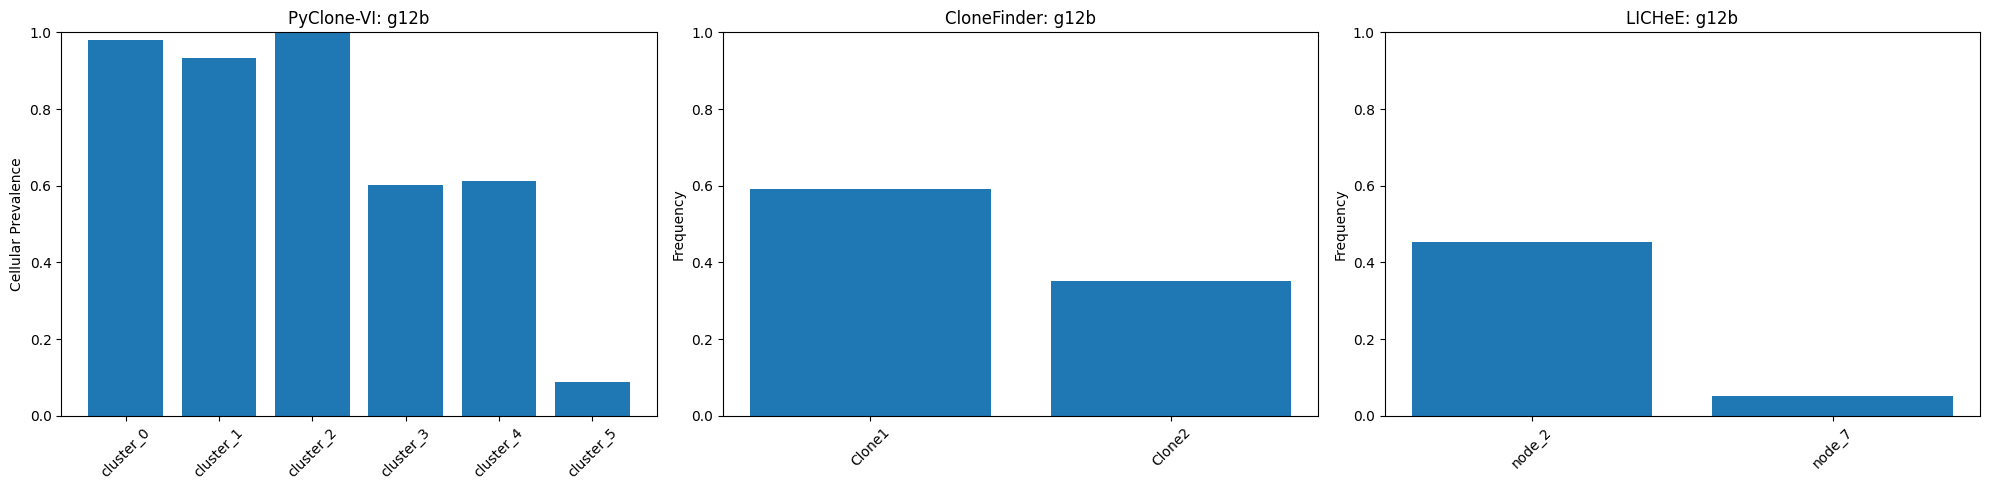

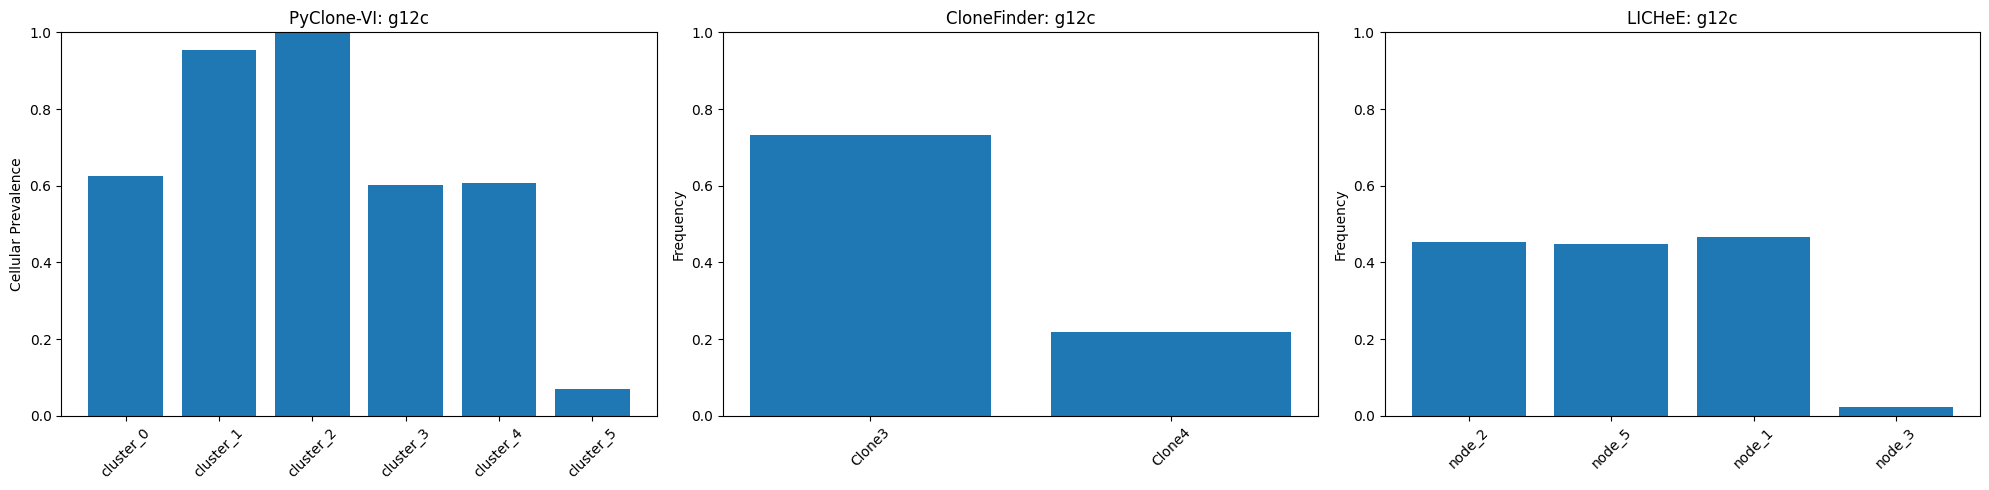

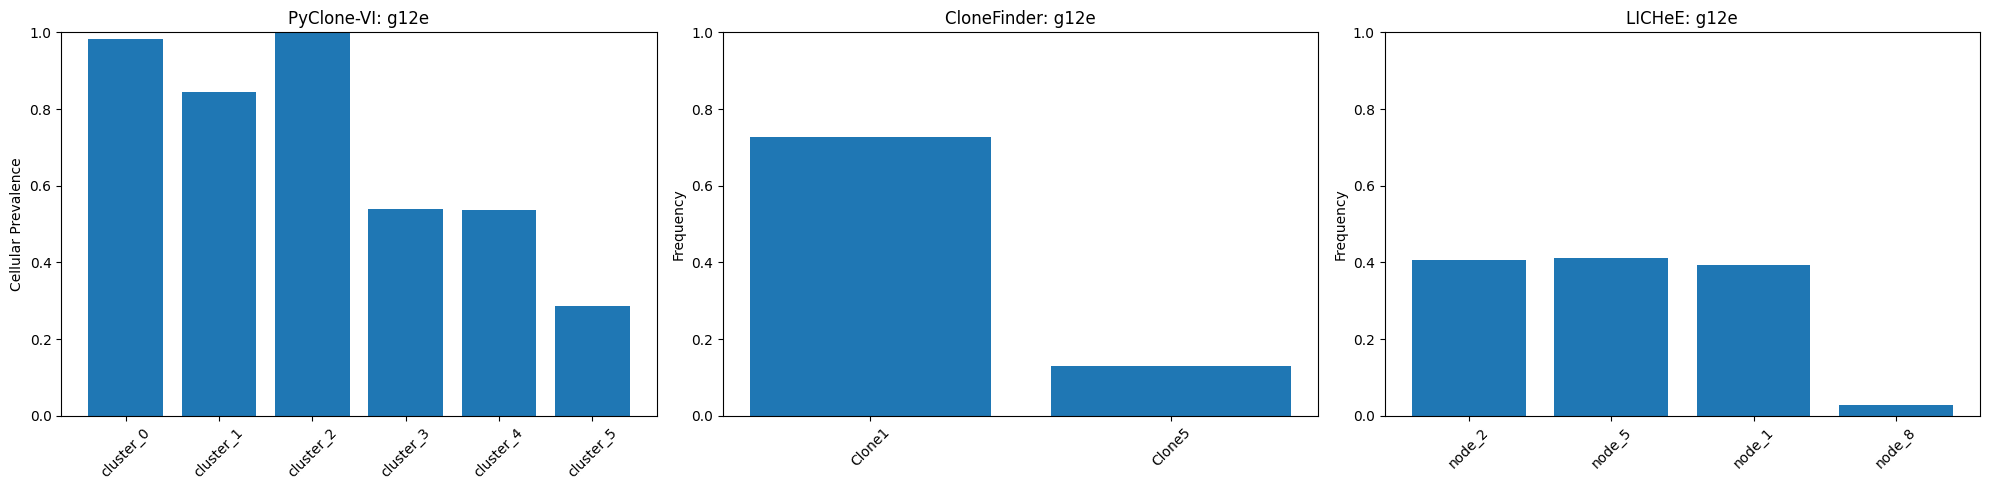

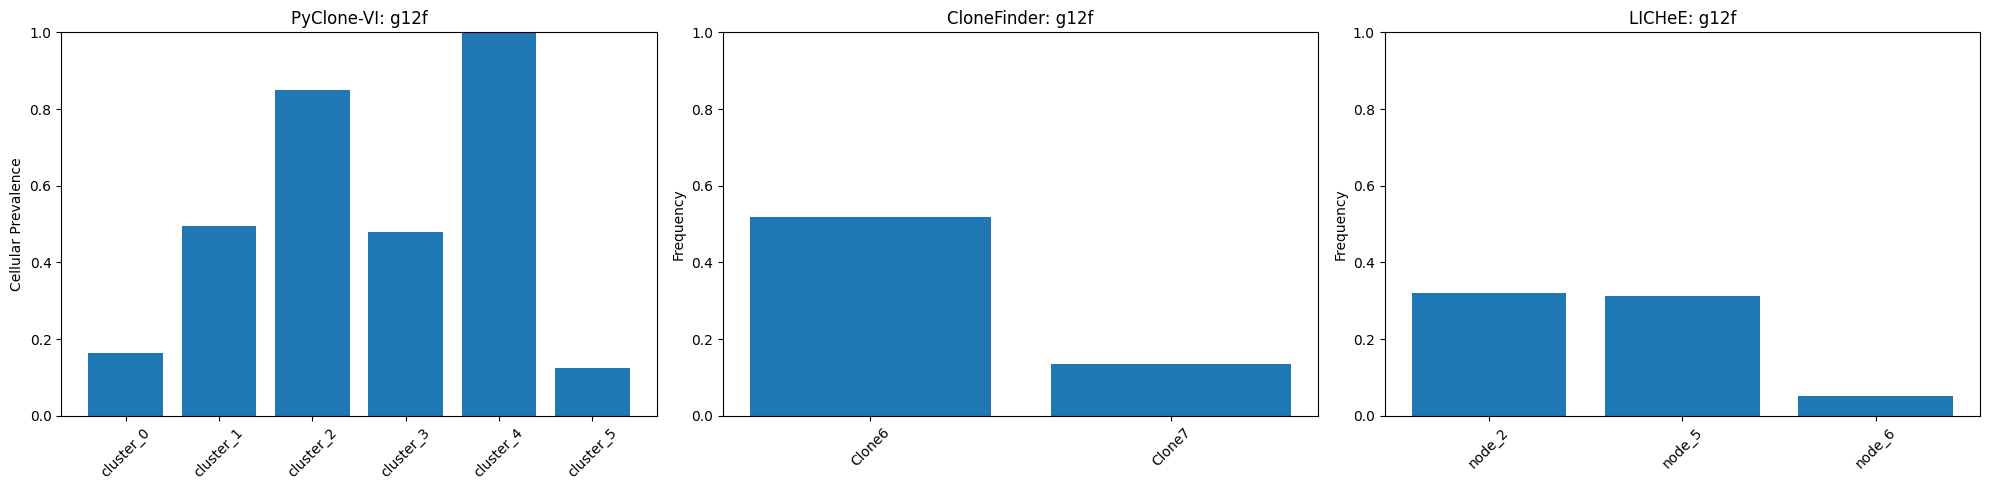

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# 1. Initialize the comparison tool
pyclone_file = "pyclone_results.tsv"
clonefinder_file = "clonefinder_inputsnv_CloneFinder.txt"
lichee_file = "lichee_input.txt.trees.txt"

# Create the tool instance
comparer = ClonalComparisonTool(
    pyclone_file=pyclone_file, 
    clonefinder_file=clonefinder_file, 
    lichee_file=lichee_file
)

# 2. Compare clone frequencies and counts
clone_comparison = comparer.compare_clones()

# Display clone counts in a DataFrame
clone_counts_df = comparer.create_clone_count_dataframe()
display(clone_counts_df)

# 3. Plot clone frequencies for each sample
clone_freq_plots = comparer.plot_clone_frequencies(figsize=(20, 5))
# for sample, fig in clone_freq_plots.items():
#     plt.figure(fig.number)
#     plt.savefig('sine_wave.png')
#     plt.tight_layout()
#     plt.show()

In [101]:
from IPython.display import display
from PIL import Image

display(HTML(f'<img src="lichee_tree_new.png" width="600" height="500">'))